# AirBnb Price Prediction - Score Prediction Model
### Part 3/3

In the previous notebook, we built a price prediction model that used some characteristics of the Airbnb to predict a price. This could help the host decide the right price when adding a new Airbnb. The model used also the rating and location score to predict the price. In order to make the prediction, we could use two approaches:

1.   Static: We simply take the average score and use them for predicting the score;
2.   Dynamic: We predict the scores and use the predictions to also predict the price.

In this notebook, the goal is to understand if it is possible to create a model to predict the rating and location scores.




### Dependencies, Libraries and Tools

In [ ]:
# Install Spark and related dependencies
!pip install pyspark 

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                set("spark.executor.extraJavaOptions", "-XX:+UseG1GC").\
                setAppName("AirbnbPP3").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=10164f788d87dec9947e9b6e07112c9cc0ff18c07c960444711b464cc7c0d49e
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# Install and configure ngrok
!pip install pyngrok
!ngrok authtoken 2PHrKeMkk5mvdVY3dhwpeV11UP5_7tfznbJvx6L1DSvj8YD5M

# Import ngrok
from pyngrok import ngrok

# Open a ngrok tunnel on the port 4050 where Spark is running
port = '4050'
public_url = ngrok.connect(port).public_url

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=c5e84e572f8df34bb47a937075ae41efdf819ecfa963600e7e12d0eccc4c0100
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://e9d8-35-231-146-39.ngrok-free.app" -> "http://127.0.0.1:4050"


In [ ]:
#Install some other useful dependencies
import pandas as pd
import numpy as np
import json

from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

### Link to Google Drive

In [ ]:
# Define GDrive paths
GDRIVE_DIR = '/content/drive'
GDRIVE_HOME_DIR = GDRIVE_DIR + '/MyDrive'
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + '/Università/BD-Datasets'

In [ ]:
# Point Colaboratory our Google Drive
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


### Dataset

As we did in the second notebook, we start by uploading the the partially cleaned dataset from the first notebook and find the best columns to predict the scores:

In [ ]:
# Define the dataset name in GDrive
gd_df_name = "airbnb_cleaned_df.csv"

In [ ]:
# Read database into a Spark Dataframe
airbnb_df = spark.read.load(GDRIVE_DATA_DIR + '/' + gd_df_name, 
                           format='csv', 
                           sep=',', 
                           inferSchema='true', 
                           header='true')

In [ ]:
# Show if the dataset was uploaded correctly
airbnb_df.show(n=5, truncate=False)

+------------------+------------------+--------------------+-----------------+-------------------+-------------------------+--------------------+----------------------+----+-------------+---------+------------+--------+----+------------------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+------------------+------------------+------------------+-------------------+-----------------+---------------------+----------------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------+------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+-----------------+-----------------+----------------------+-----------+-----------------

# 6.1 Data Exploration and Feature Selection

In order to analyze the data and create some graphs to better visualize it, I convert the PySpark dataframe to a Pandas one. This step is also useful to select the best features to create the score prediction models.

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
airbnb_pd = airbnb_df.toPandas() 

In [ ]:
# Set some default plotting configuration using seaborn properties
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2, 
                                "xtick.labelsize": 14, 
                                "ytick.labelsize": 14,
                                "axes.labelsize": 18
                                })

First of all, let's analyze the scores. As we said before, we want to predict the location score and the rating score without considering the price (since we want to use the predicted values to predict the price). Let's visualize the distribution of the scores to see their behavior: 

Text(0.5, 0.98, 'Distibution of scores')

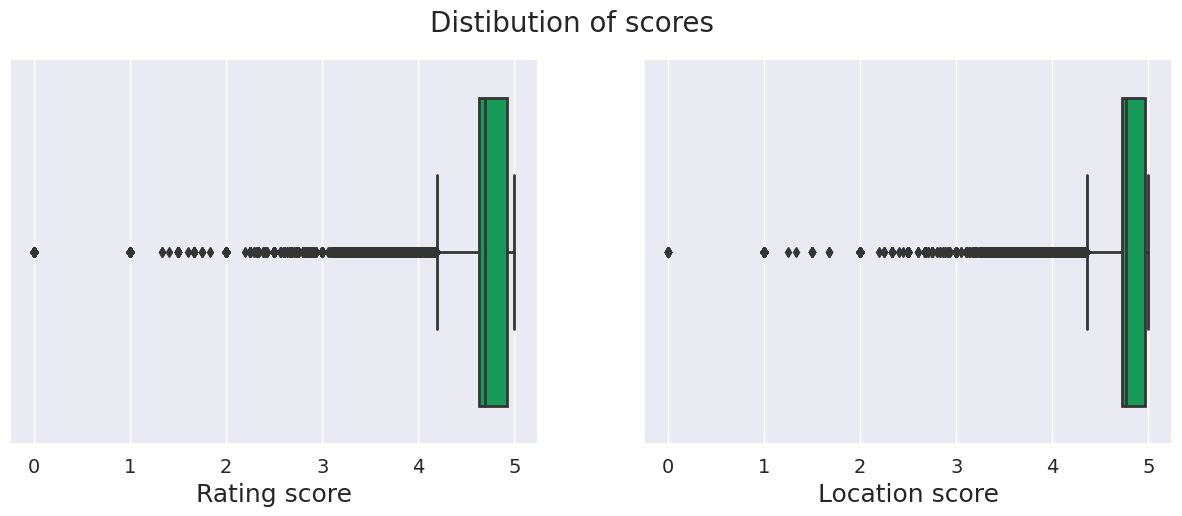

In [ ]:
# Score boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = 'review_scores_rating', hue = 'review_scores_rating', color ='#00b159', ax = ax1)
ax1.set(xlabel='Rating score')
sns.boxplot(data = airbnb_pd, x = 'review_scores_location', hue = 'review_scores_location', color ='#00b159', ax = ax2)
ax2.set(xlabel='Location score')
fig.suptitle('Distibution of scores', fontsize=20)

As we already noticed before, the score is a value between 0 and 5. The interesting thing to notice is that the distribution of both is left skewed so most of the scores are above 4.5.

In [ ]:
# Print the number of scores below a certain value
print("The number of Airbnbs with a rating score smaller than 2.5: " + str(airbnb_df.select(expr("sum(CASE WHEN review_scores_rating<=2.5 THEN 1 ELSE 0 END)")).collect()[0][0]))
print("The number of Airbnbs with a location score smaller than 2.5: " + str(airbnb_df.select(expr("sum(CASE WHEN review_scores_location<=2.5 THEN 1 ELSE 0 END)")).collect()[0][0]))

The number of Airbnbs with a rating score smaller than 2.5: 4208
The number of Airbnbs with a location score smaller than 2.5: 935


I remove Airbnb with a score too low since they might not be objective reviews and might affect the results too much. This means that predictions given by the models will have a value between 2.5 and 5.

In [ ]:
# Remove the Airbnb with a score too low
airbnb_df = airbnb_df.filter(col('review_scores_rating') > 2.5).filter(col('review_scores_location') > 2.5)

In [ ]:
# Let's also update the Pandas dataframe so that we keep the two dataframes aligned
airbnb_pd = airbnb_pd[airbnb_pd['review_scores_rating'] > 2.5]
airbnb_pd = airbnb_pd[airbnb_pd['review_scores_location'] > 2.5]

Now, let's see if there are some correlations among the features and the target variables (review_scores_ratings and review_scores_location). Let's start by looking at the relationship between host information and those features:

In [ ]:
# Remove outliers in the host_total_listings_count column (in particular a value of 25k listings)
airbnb_df = airbnb_df.filter(col('host_total_listings_count') < 10000)
airbnb_pd = airbnb_pd[airbnb_pd['host_total_listings_count'] < 10000]

In [ ]:
# Host information categorical values
host_information_cat_features = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_response_time', 'is_email_verified', 'is_phone_verified', 'is_work_email_verified']

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

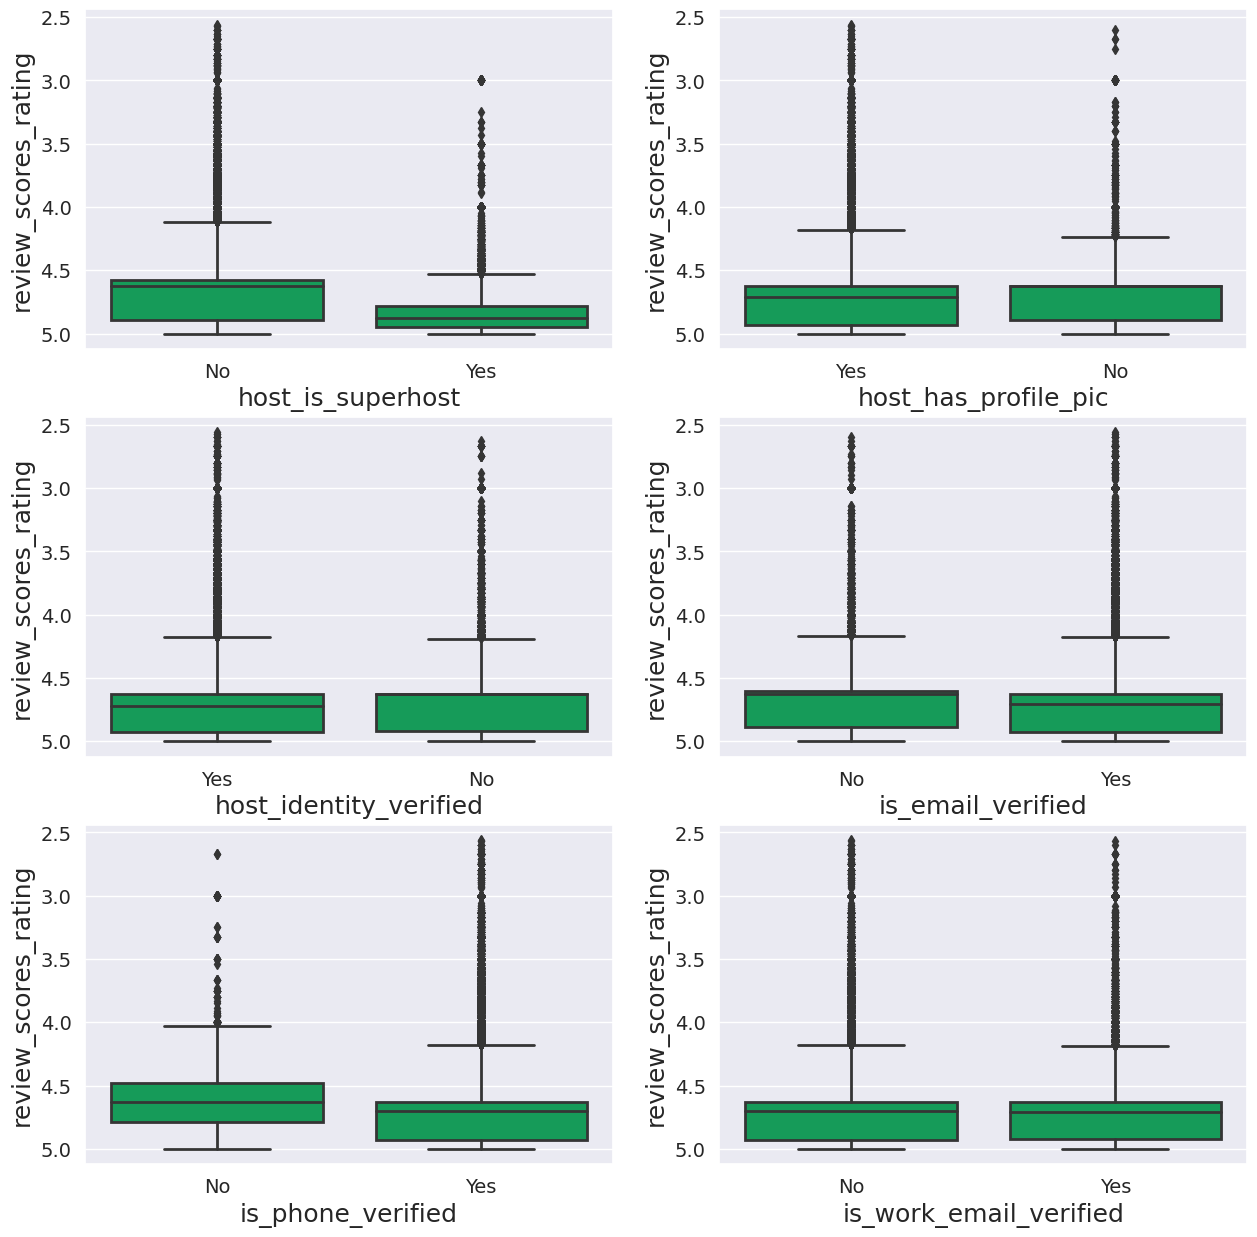

In [ ]:
# Host information boxplots (for categorical features) and review_scores_rating
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[0], y = 'review_scores_rating', color ='#00b159', ax = ax1).invert_yaxis()
ax1.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[1], y = 'review_scores_rating', color ='#00b159', ax = ax2).invert_yaxis()
ax2.set_xticklabels(['Yes', 'No'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[2], y = 'review_scores_rating', color ='#00b159', ax = ax3).invert_yaxis()
ax3.set_xticklabels(['Yes', 'No'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[4], y = 'review_scores_rating', color ='#00b159', ax = ax4).invert_yaxis()
ax4.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[5], y = 'review_scores_rating', color ='#00b159', ax = ax5).invert_yaxis()
ax5.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[6], y = 'review_scores_rating', color ='#00b159', ax = ax6).invert_yaxis()
ax6.set_xticklabels(['No', 'Yes'])

[Text(0, 0, 'Within an hour'),
 Text(1, 0, 'Unknown'),
 Text(2, 0, 'Within a few hours'),
 Text(3, 0, 'Within a day'),
 Text(4, 0, 'A few days or more')]

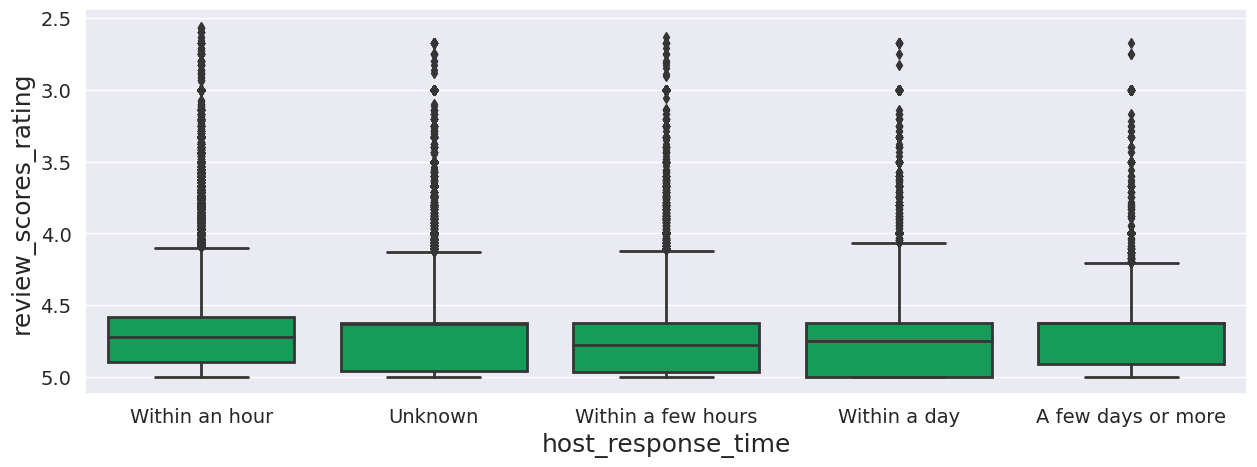

In [ ]:
# Host information boxplots (for categorical features - host_response_time) and review_scores_rating
fig, ax = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[3], y = 'review_scores_rating', color ='#00b159', ax = ax).invert_yaxis()
ax.set_xticklabels(['Within an hour', 'Unknown', 'Within a few hours', 'Within a day', 'A few days or more'])

In [ ]:
# Host information numerical values
host_information_num_features = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count']

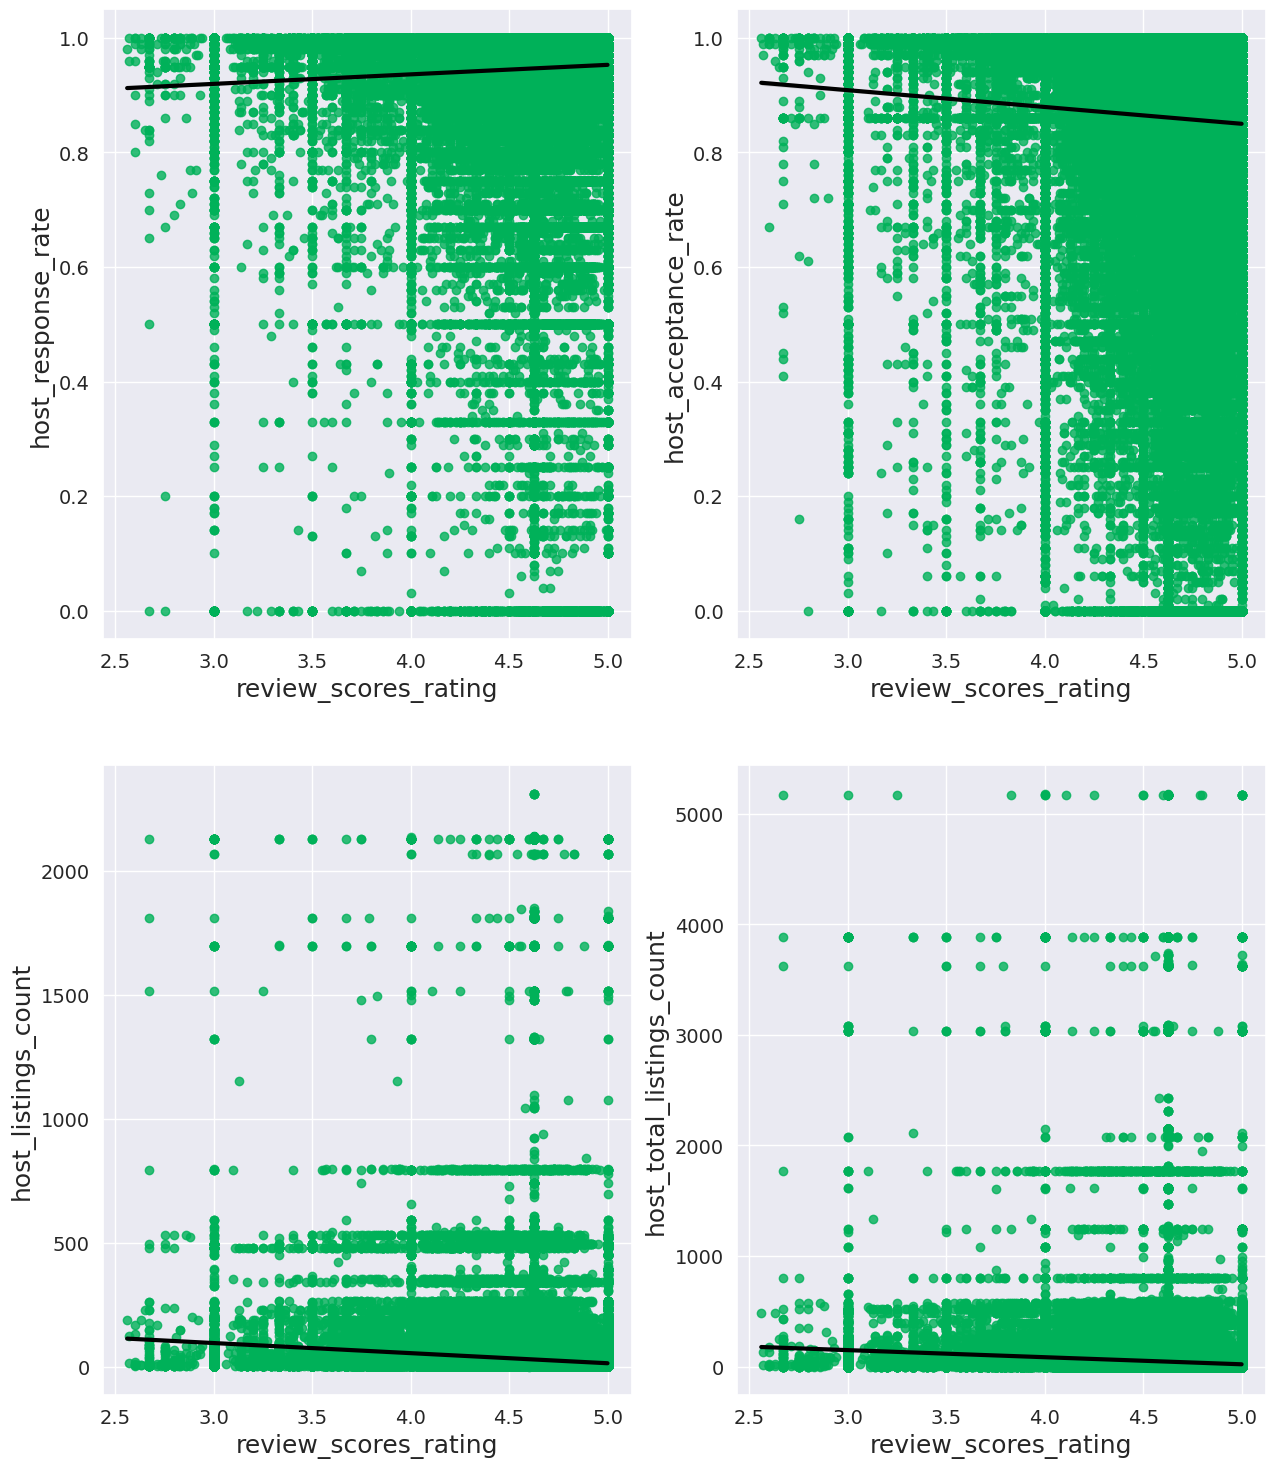

In [ ]:
# Host information scatterplots (for numerical features) and review_scores_rating
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,18))
for i, f in enumerate(host_information_num_features):
  _ = sns.regplot(data = airbnb_pd, y = f, x = 'review_scores_rating', scatter_kws={'color': '#00b159'}, line_kws={'color': 'black'}, ax=axes[i//n_cols, i%n_cols])


[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

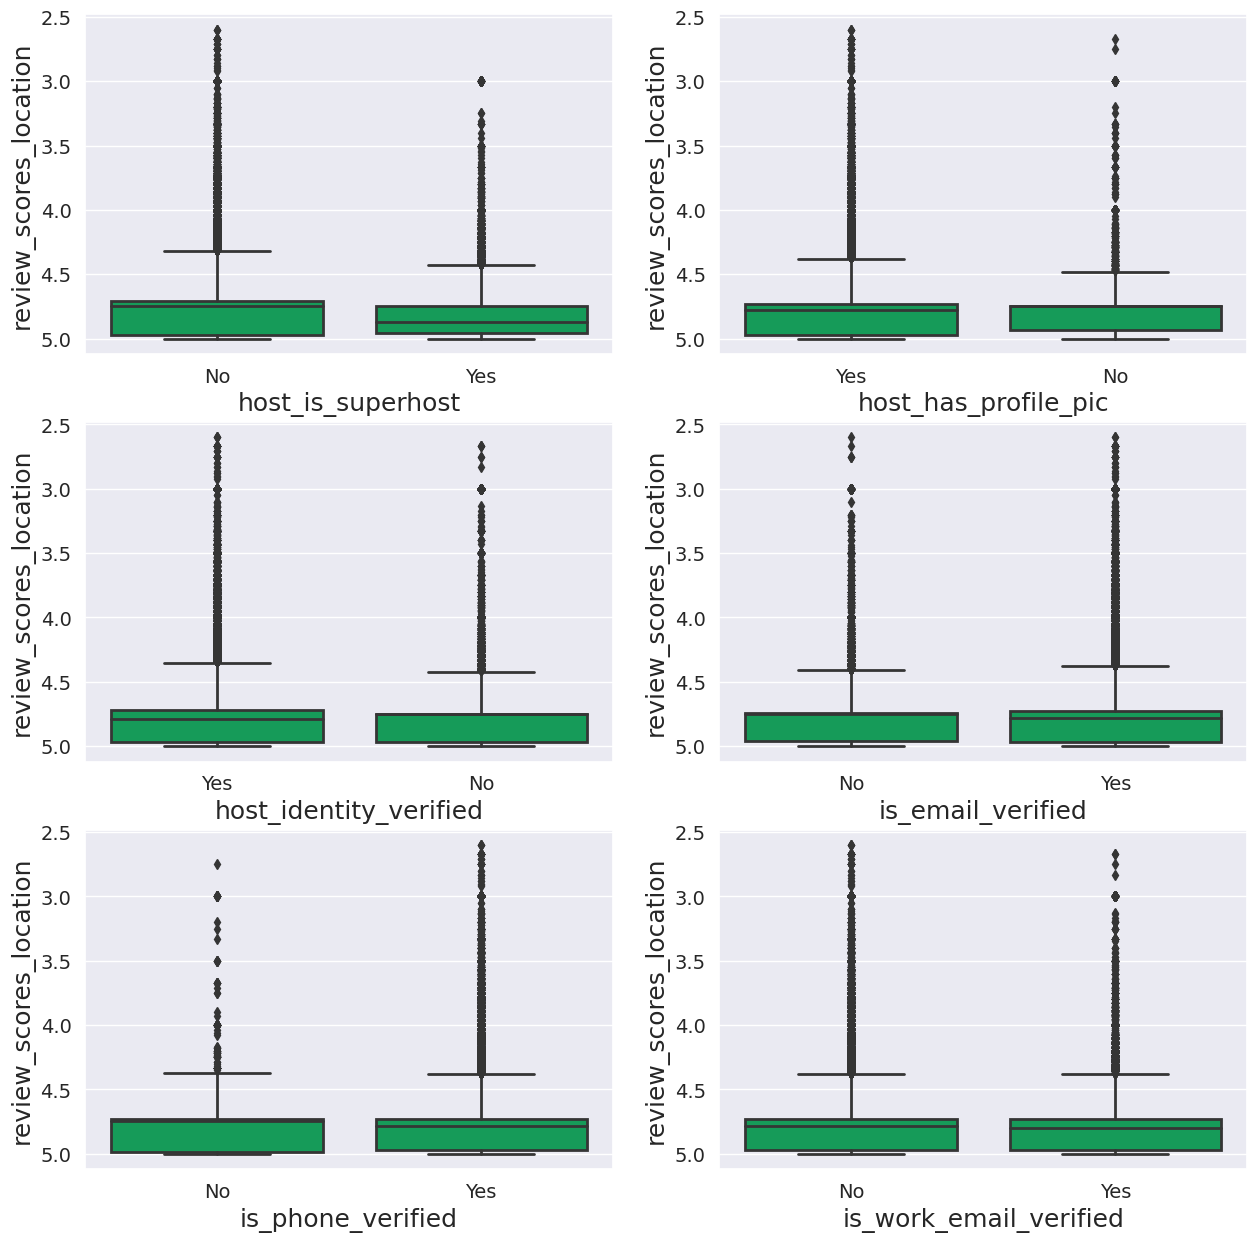

In [ ]:
# Host information boxplots (for categorical features) and review_scores_location
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[0], y = 'review_scores_location', color ='#00b159', ax = ax1).invert_yaxis()
ax1.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[1], y = 'review_scores_location', color ='#00b159', ax = ax2).invert_yaxis()
ax2.set_xticklabels(['Yes', 'No'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[2], y = 'review_scores_location', color ='#00b159', ax = ax3).invert_yaxis()
ax3.set_xticklabels(['Yes', 'No'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[4], y = 'review_scores_location', color ='#00b159', ax = ax4).invert_yaxis()
ax4.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[5], y = 'review_scores_location', color ='#00b159', ax = ax5).invert_yaxis()
ax5.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[6], y = 'review_scores_location', color ='#00b159', ax = ax6).invert_yaxis()
ax6.set_xticklabels(['No', 'Yes'])

[Text(0, 0, 'Within an hour'),
 Text(1, 0, 'Unknown'),
 Text(2, 0, 'Within a few hours'),
 Text(3, 0, 'Within a day'),
 Text(4, 0, 'A few days or more')]

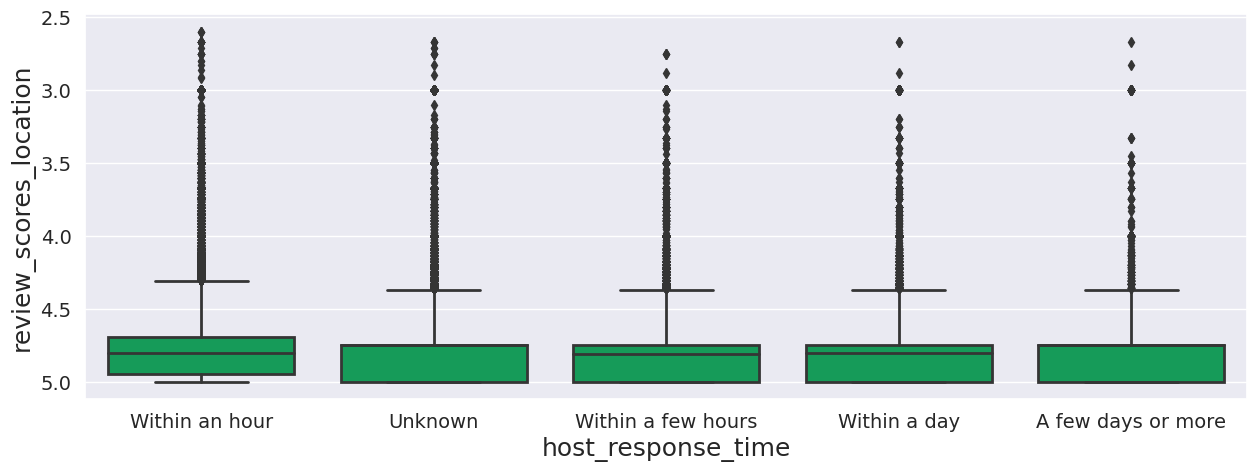

In [ ]:
# Host information boxplots (for categorical features - host_response_time) and review_scores_location
fig, ax = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = host_information_cat_features[3], y = 'review_scores_location', color ='#00b159', ax = ax).invert_yaxis()
ax.set_xticklabels(['Within an hour', 'Unknown', 'Within a few hours', 'Within a day', 'A few days or more'])

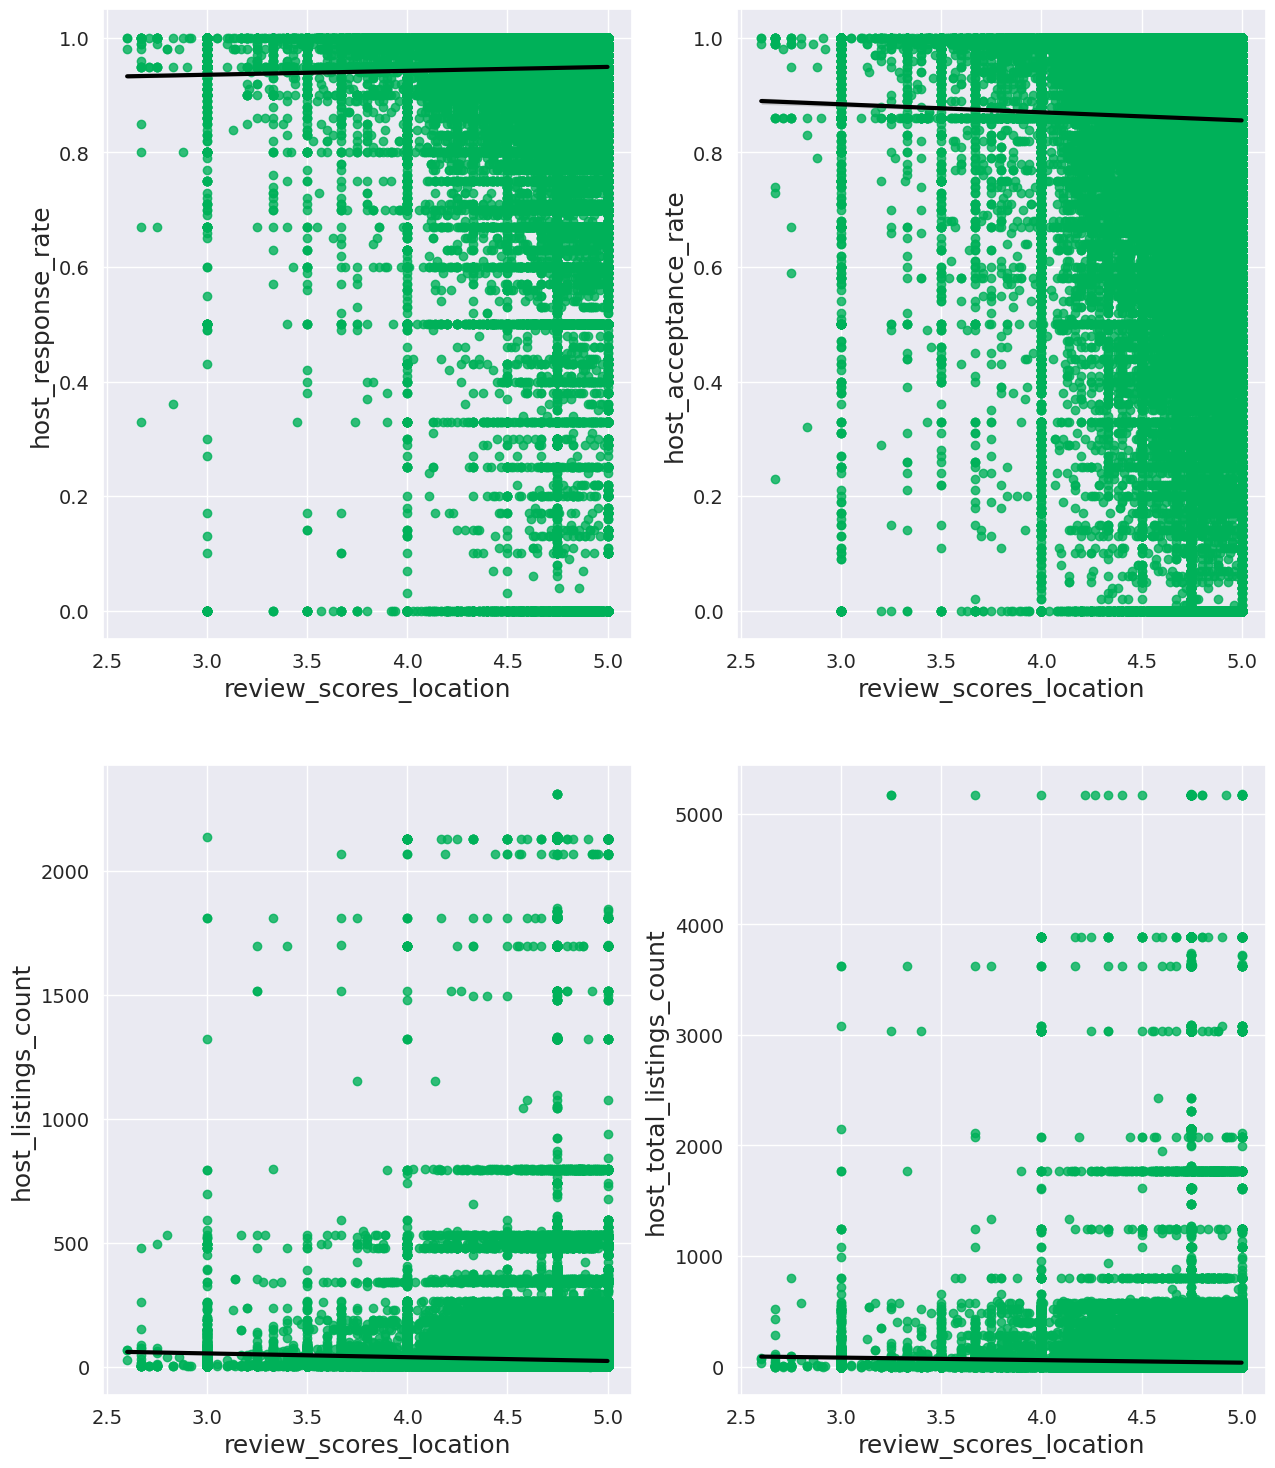

In [ ]:
# Host information scatterplots (for numerical features) and review_scores_location
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,18))
for i, f in enumerate(host_information_num_features):
  _ = sns.regplot(data=airbnb_pd, y=f, x='review_scores_location', scatter_kws={'color': '#00b159'}, line_kws={'color': 'black'}, ax=axes[i//n_cols, i%n_cols])

In [ ]:
# Aggregate host information features for correlation analysis
host_information_features = host_information_num_features+host_information_cat_features+['review_scores_rating', 'review_scores_location']

<Axes: >

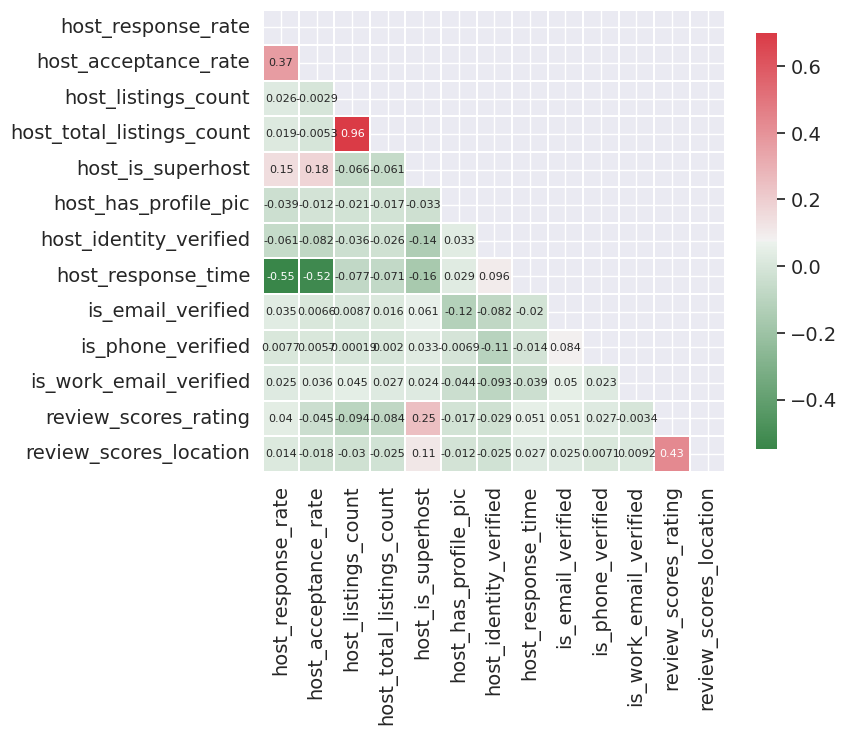

In [ ]:
# Correlation between host information features and scores
mask = np.zeros_like(airbnb_pd[host_information_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[host_information_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

From the previous graphs, it is possible to notice that the only information correlated with the scores is the host is a superhost feature. In fact we have a moderate correlation (still pretty low though) with the rating score (and surprisingly there is also a discrete correlation with the location score). Also, it looks that if the user is verified (by email, phone or work_email), the rating score tends to be slightly higher. Again, there is no clear correlation with the profile pic so we can immediately remove that feature. Concerning the other features we can only notice how the scores grow when the number of listings are lower. The other features don’t look too relevant so we’ll decide later if to consider them or not.

In [ ]:
# Drop some columns
airbnb_df = airbnb_df.drop('host_has_profile_pic')

Now, let's see if cities have a different average reviews:

In [ ]:
# Print the average rating score of the cities
avg_review_scores_rating_by_city = airbnb_pd.groupby('city')['review_scores_rating'].mean()
print(avg_review_scores_rating_by_city)

city
0     4.682708
1     4.676911
2     4.702411
3     4.656681
4     4.685485
5     4.600566
6     4.627887
7     4.714438
8     4.719075
9     4.744422
10    4.693734
11    4.684762
12    4.806056
13    4.678750
14    4.752413
Name: review_scores_rating, dtype: float64


In [ ]:
# Print the average location score of the cities
avg_review_scores_location_by_city = airbnb_pd.groupby('city')['review_scores_location'].mean()
print(avg_review_scores_location_by_city)

city
0     4.752071
1     4.800304
2     4.751877
3     4.778919
4     4.725982
5     4.762183
6     4.741171
7     4.735962
8     4.762283
9     4.743564
10    4.767622
11    4.736550
12    4.785881
13    4.726010
14    4.791389
Name: review_scores_location, dtype: float64


As we can see, the scores are more or less the same in all cities. Let's see now if the features on the location information we added before actually helps determining the price of an accommodation:

In [ ]:
# Collect names of distance features
location_features = ['review_scores_rating', 'review_scores_location', 'station_dist', 'city_center_dist', 'poi_dist']

<Axes: >

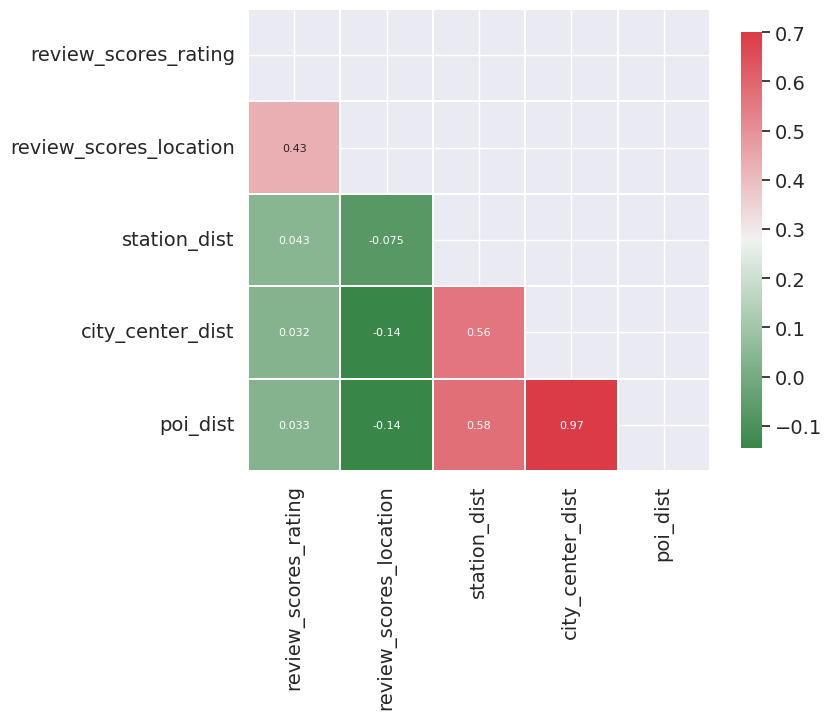

In [ ]:
# Correlation between distance features and score
mask = np.zeros_like(airbnb_pd[location_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[location_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

As we could imagine, the location score has a negative correlation with the city center distance and station distance. This means that the higher the distance, the lower the location score. This means that the distances are important while determining the location scores. Concerning the rating score, surprisingly the trend is quite the opposite. Now, let's see what happens with the accommodation features. First of all, let's remove some outliers as we did with the price:

In [ ]:
# Print the number of outliers (hard approach)
print("The number of Airbnbs with more than 5 bedrooms: " + str(airbnb_df.select(expr("sum(CASE WHEN bedrooms>5 THEN 1 ELSE 0 END)")).collect()[0][0]))
print("The number of Airbnbs with more than 10 beds: " + str(airbnb_df.select(expr("sum(CASE WHEN beds>10 THEN 1 ELSE 0 END)")).collect()[0][0]))
print("The number of Airbnbs with more than 4 bathrooms: " + str(airbnb_df.select(expr("sum(CASE WHEN n_bathrooms>4 THEN 1 ELSE 0 END)")).collect()[0][0]))
print("The number of Airbnbs with more than 10 accommodates: " + str(airbnb_df.select(expr("sum(CASE WHEN accommodates>10 THEN 1 ELSE 0 END)")).collect()[0][0]))

The number of Airbnbs with more than 5 bedrooms: 840
The number of Airbnbs with more than 10 beds: 550
The number of Airbnbs with more than 4 bathrooms: 1039
The number of Airbnbs with more than 10 accommodates: 1836


In [ ]:
# Remove the number of Airbnbs with a high number of bedrooms/beds/bathrooms
airbnb_df = airbnb_df.filter(col('bedrooms') <= 5).filter(col('beds') <= 10).filter(col('n_bathrooms') <= 4).filter(col('n_bathrooms') <= 10)

In [ ]:
# Let's also update the Pandas dataframe so that we keep the two dataframes aligned
airbnb_pd = airbnb_pd[airbnb_pd['bedrooms'] <= 5]
airbnb_pd = airbnb_pd[airbnb_pd['beds'] <= 10]
airbnb_pd = airbnb_pd[airbnb_pd['n_bathrooms'] <= 4]
airbnb_pd = airbnb_pd[airbnb_pd['accommodates'] <= 10]

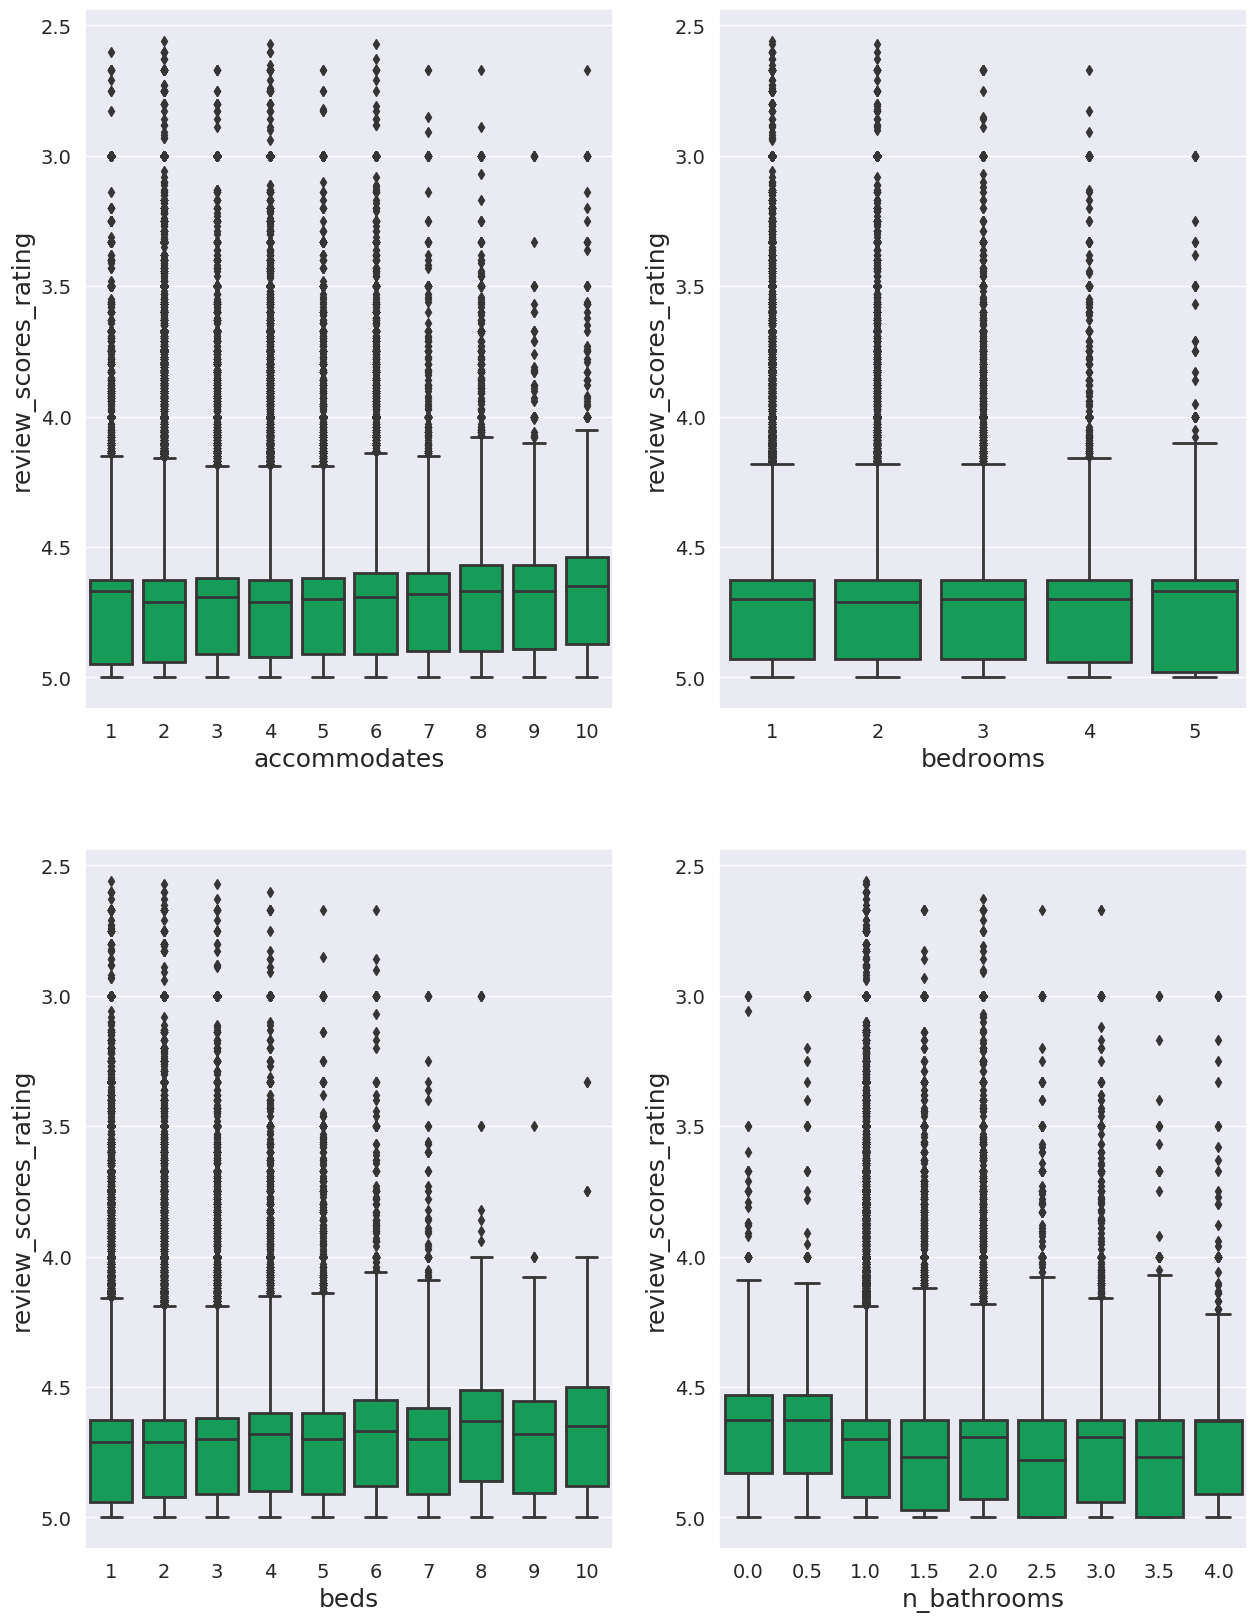

In [ ]:
# Visualize the variation of rating score changing the characteristics of the Airbnb
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,20))
for i, f in enumerate(['accommodates', 'bedrooms', 'beds', 'n_bathrooms']):
  _ = sns.boxplot(data = airbnb_pd, x = f, y = 'review_scores_rating', color ='#00b159', ax=axes[i//n_cols, i%n_cols]).invert_yaxis()

We can notice how the average rating score slightly decreases as the number of accommodations, beds and bedrooms arise (in general, the bigger the accommodation, the lower the rating score). Concerning the number of bathrooms, there is no clear trend.

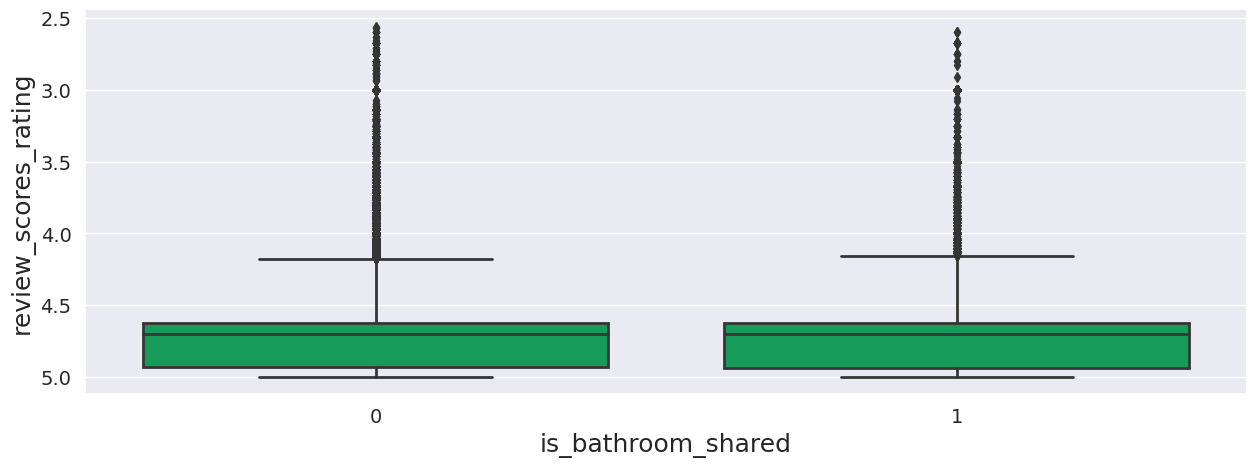

In [ ]:
# Visualize the variation of rating score changing the characteristics of the Airbnb (bathroom shared)
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = 'is_bathroom_shared', y = 'review_scores_rating', color='#00b159', ax=ax1).invert_yaxis()

In [ ]:
# Print all unique "is_bathroom shared" in the dataset
airbnb_df.groupBy("is_bathroom_shared").agg(count('*')).show()

+------------------+--------+
|is_bathroom_shared|count(1)|
+------------------+--------+
|                 1|   44089|
|                 0|  245328|
+------------------+--------+



 Also, there is no difference if the bathroom is shared or not. Let's analyze the remaining features:

[Text(0, 0, 'Entire home/apt'),
 Text(1, 0, 'Private room'),
 Text(2, 0, 'Hotel room'),
 Text(3, 0, 'Shared room')]

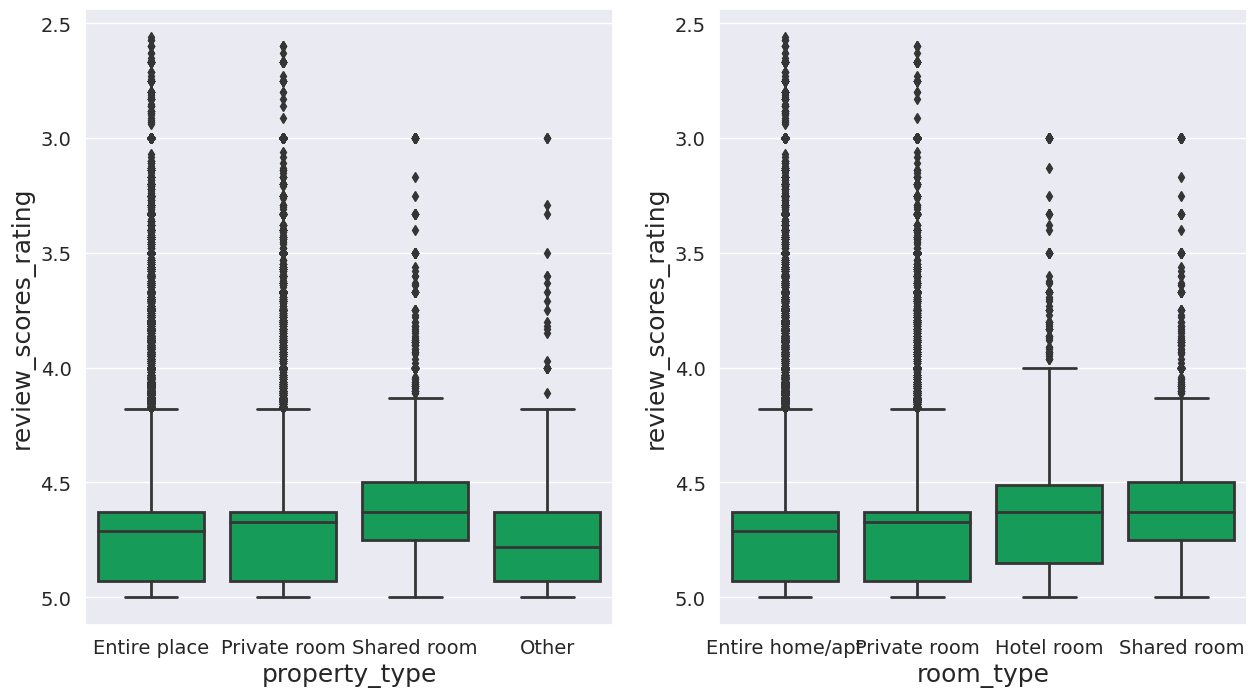

In [ ]:
# Visualize the variation of rating score changing the characteristics of the Airbnb (property and room type)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(data = airbnb_pd, x = 'property_type', y = 'review_scores_rating', color='#00b159', ax=ax1).invert_yaxis()
ax1.set_xticklabels(['Entire place', 'Private room', 'Shared room', 'Other'])
sns.boxplot(data = airbnb_pd, x = 'room_type', y = 'review_scores_rating', color='#00b159', ax=ax2).invert_yaxis()
ax2.set_xticklabels(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'])

While there are no differences between private rooms and the entire place (that is again private), the shared and hotel rooms have a lower rating score. Now, let's do the same for the location score:

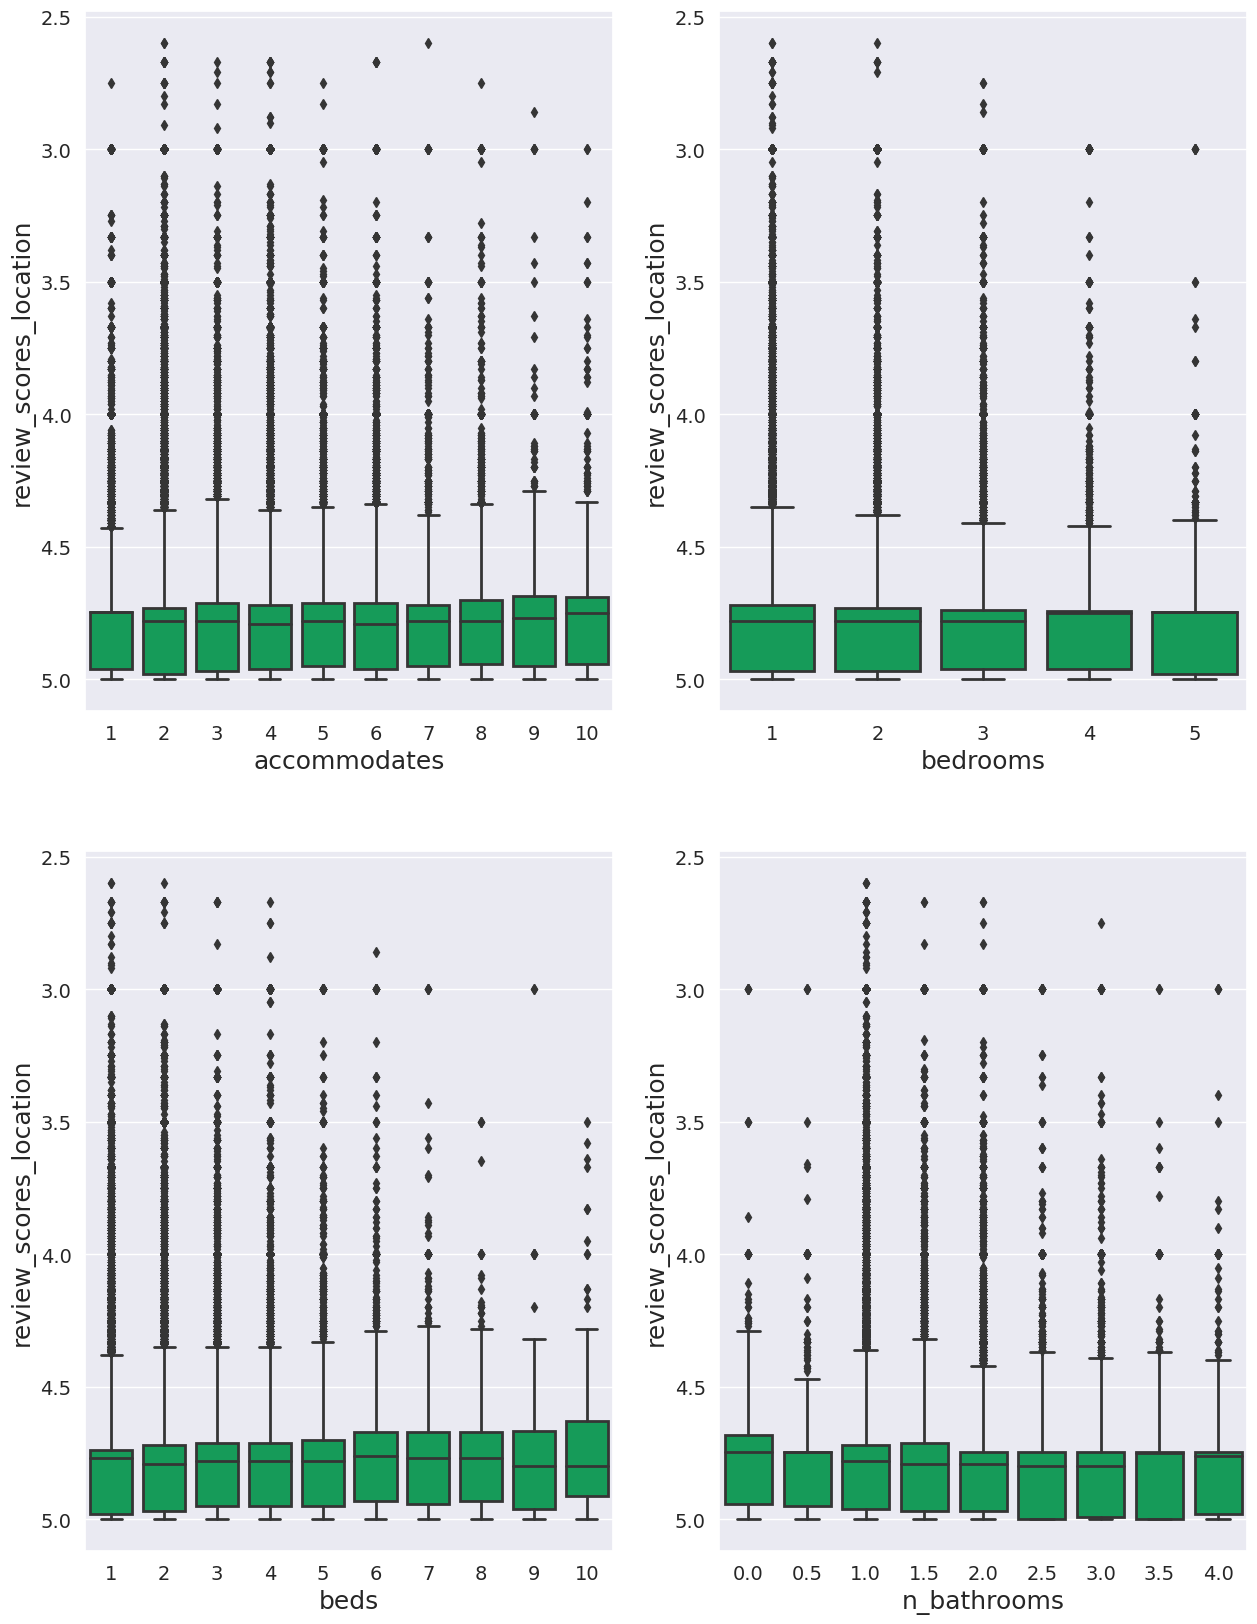

In [ ]:
# Visualize the variation of location score changing the characteristics of the Airbnb
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,20))
for i, f in enumerate(['accommodates', 'bedrooms', 'beds', 'n_bathrooms']):
  _ = sns.boxplot(data = airbnb_pd, x = f, y = 'review_scores_location', color ='#00b159', ax=axes[i//n_cols, i%n_cols]).invert_yaxis()

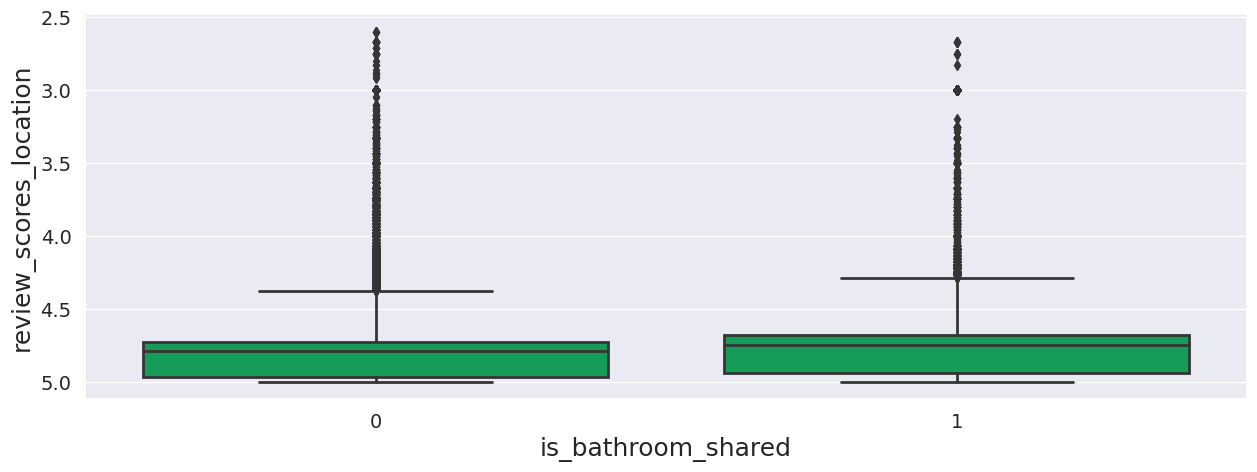

In [ ]:
# Visualize the variation of location score changing the characteristics of the Airbnb (bathroom shared)
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = 'is_bathroom_shared', y = 'review_scores_location', color='#00b159', ax=ax1).invert_yaxis()

[Text(0, 0, 'Entire home/apt'),
 Text(1, 0, 'Private room'),
 Text(2, 0, 'Hotel room'),
 Text(3, 0, 'Shared room')]

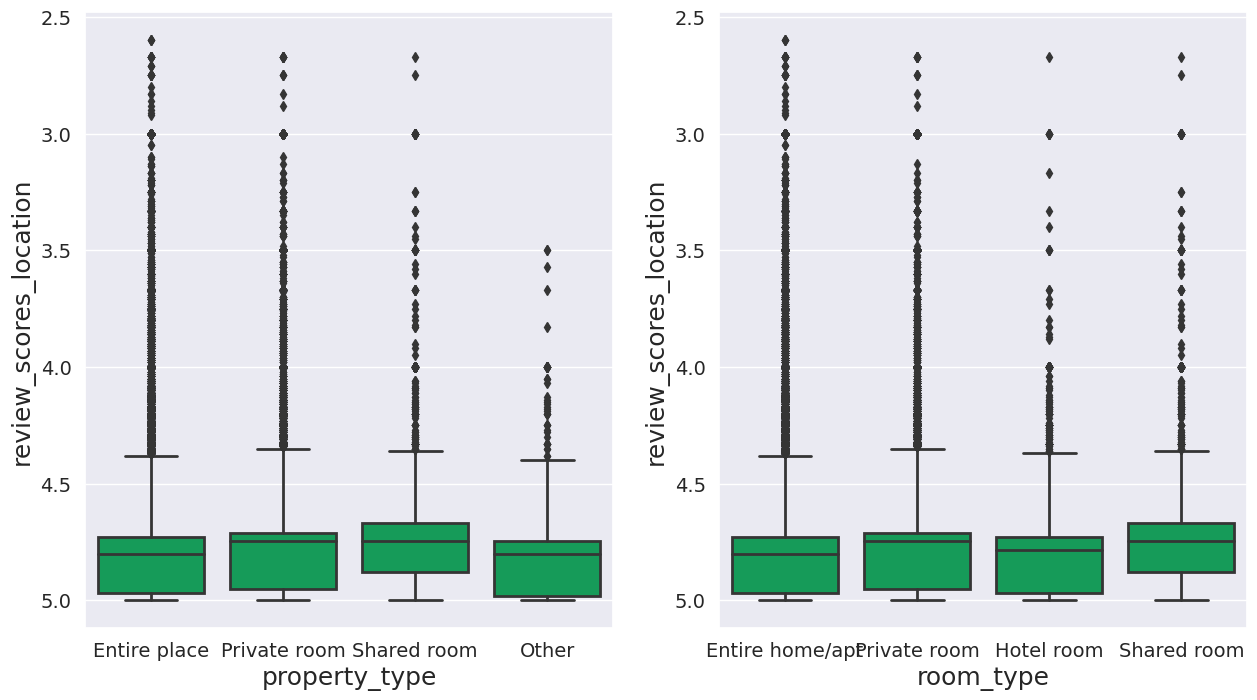

In [ ]:
# Visualize the variation of location score changing the characteristics of the Airbnb (property and room type)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(data = airbnb_pd, x = 'property_type', y = 'review_scores_location', color='#00b159', ax=ax1).invert_yaxis()
ax1.set_xticklabels(['Entire place', 'Private room', 'Shared room', 'Other'])
sns.boxplot(data = airbnb_pd, x = 'room_type', y = 'review_scores_location', color='#00b159', ax=ax2).invert_yaxis()
ax2.set_xticklabels(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'])

The only difference here is the property/room type where we have a gap between private and shared rooms. The other features seem uncorrelated.

In [ ]:
# List the features that describe the characteristics of the Airbnb
accomodation_features = ['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'n_bathrooms', 'is_bathroom_shared', 'review_scores_rating', 'review_scores_location']

<Axes: >

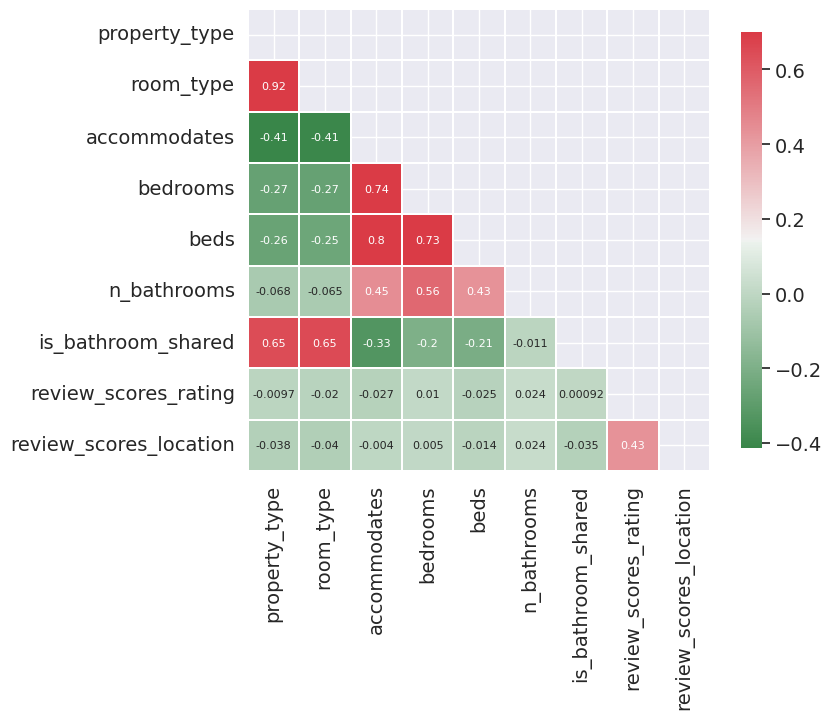

In [ ]:
# Correlation between the characteristic features and scores
mask = np.zeros_like(airbnb_pd[accomodation_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[accomodation_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

Room type and property type are highly correlated (almost completely) so we can immediatly remove one of them (we keep the room type as it is able to also describe the property type someway). Concerning the other features, the correlation is not so high actually. We'll eventually see if we consider them or not.

In [ ]:
# Drop some columns
airbnb_df = airbnb_df.drop('property_type')

Now, there is a bunch of features describing the minimum and maximum nights a guest can stay in the Airbnb along with some statistical features (e.g. the average). Let's see if they can help determining the scores:

In [ ]:
# List the features that describe the minimum/maximum period of stay
period_stay_features = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'review_scores_rating', 'review_scores_location']

<Axes: >

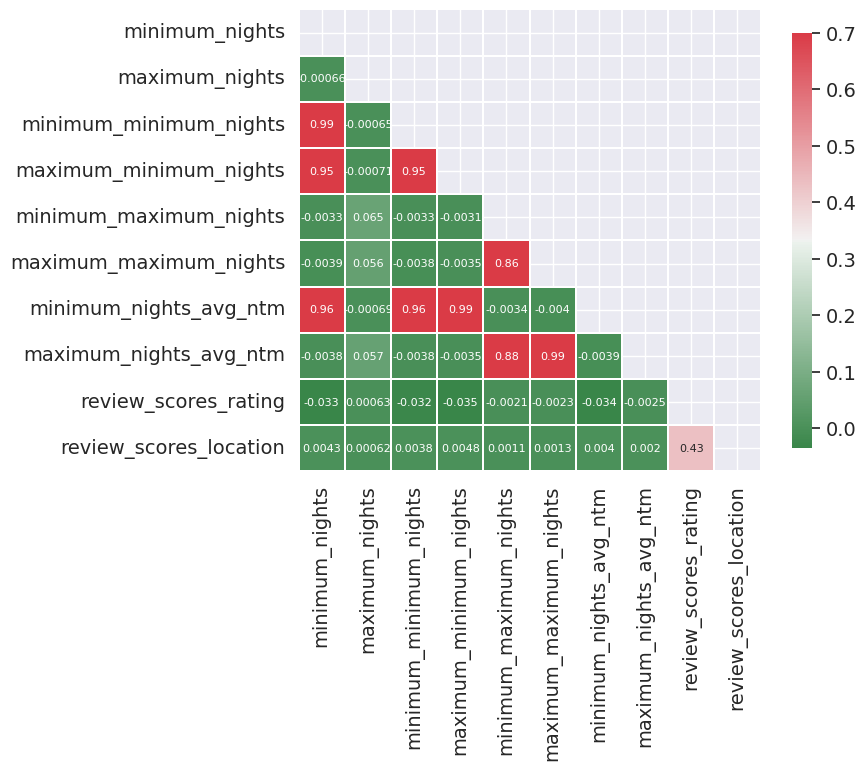

In [ ]:
# Correlation between the period of stay and scores
mask = np.zeros_like(airbnb_pd[period_stay_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[period_stay_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

Some of the features are similar to each other but none of them is actually helpful for determining the scores so we can remove them all:

In [ ]:
# Remove some columns
airbnb_df = airbnb_df.drop('minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm')

Now, let's evaluate the features concerning the availability. There are some features describing how much time the Airbnb is available (e.g. how many days in a month, one many days in three months, how many days in a year, etc..). Let's see it is someway linked to the scores:

In [ ]:
# List the features that describe the minimum/maximum period of stay
availability_features = ['has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'review_scores_rating', 'review_scores_location']

<Axes: >

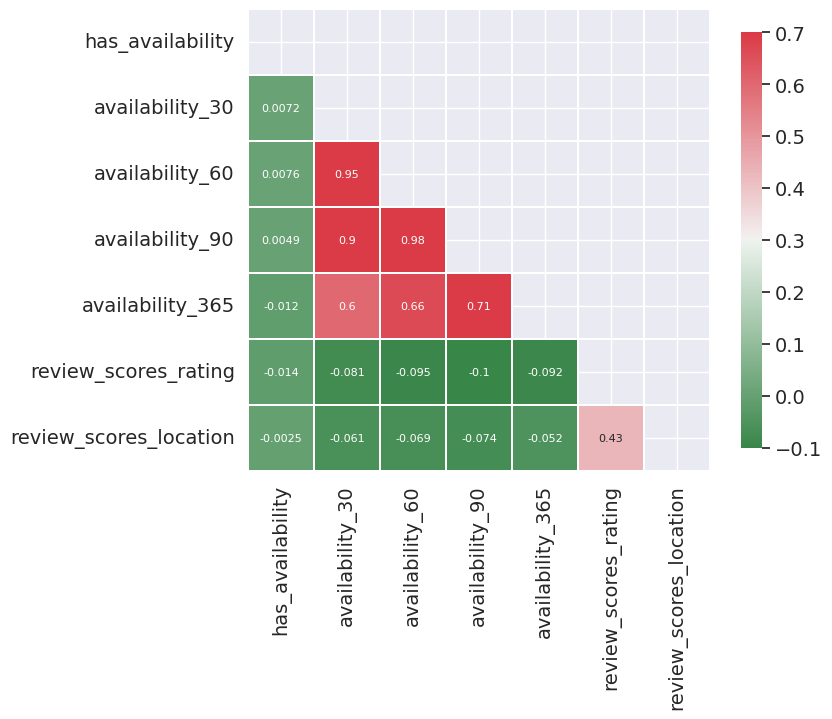

In [ ]:
# Correlation between the availability and scores
mask = np.zeros_like(airbnb_pd[availability_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[availability_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

It looks that rating score and availability features have a moderate negative correlation meaning that the rating score decreases if the accommodation is available for a higher amount of time. Concerning the location score, there is no clear trend. I leave only the "availability_365" that is kind of able to represent also the other ones:

In [ ]:
# Remove some columns
airbnb_df = airbnb_df.drop('has_availability', 'availability_30', 'availability_60', 'availability_90')

Let's see if something changes if the Airbnb is instantly bookable or not:

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

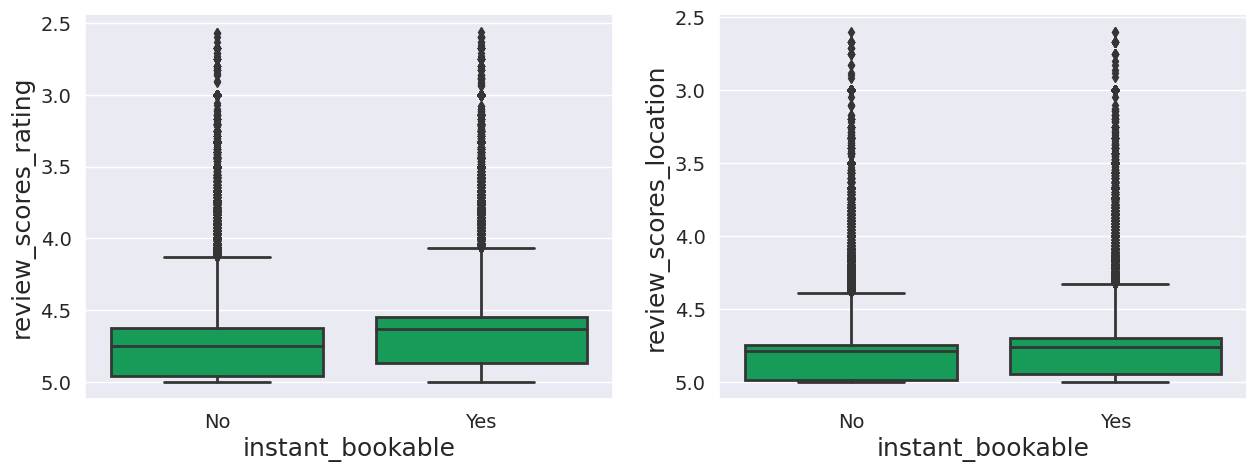

In [ ]:
# Visualize the change of the score depending if the accommodation is instantly bookable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(data = airbnb_pd, x = 'instant_bookable', y = 'review_scores_rating', color='#00b159', ax=ax1).invert_yaxis()
ax1.set_xticklabels(['No', 'Yes'])
sns.boxplot(data = airbnb_pd, x = 'instant_bookable', y = 'review_scores_location', color='#00b159', ax=ax2).invert_yaxis()
ax2.set_xticklabels(['No', 'Yes'])

<Axes: >

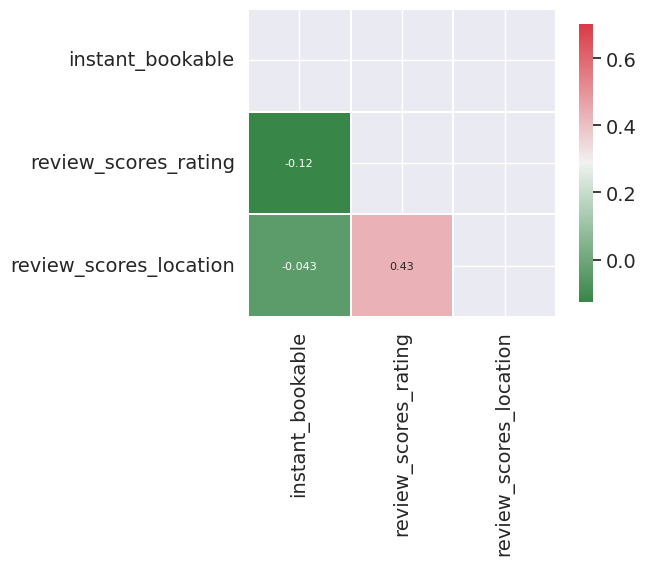

In [ ]:
# Correlation between the instant_bookable feature and scores
mask = np.zeros_like(airbnb_pd[['instant_bookable', 'review_scores_rating', 'review_scores_location']].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(6, 4))           
sns.heatmap(airbnb_pd[['instant_bookable', 'review_scores_rating', 'review_scores_location']].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

It looks that the scores (especially the rating score) slightly decreases if the accommodation is instantly bookable. Now, there are some features regarding the number of the host's listings. let's see if they have an impact on the scores:


In [ ]:
# Define host listings features
host_listings_features = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'review_scores_rating', 'review_scores_location']

<Axes: >

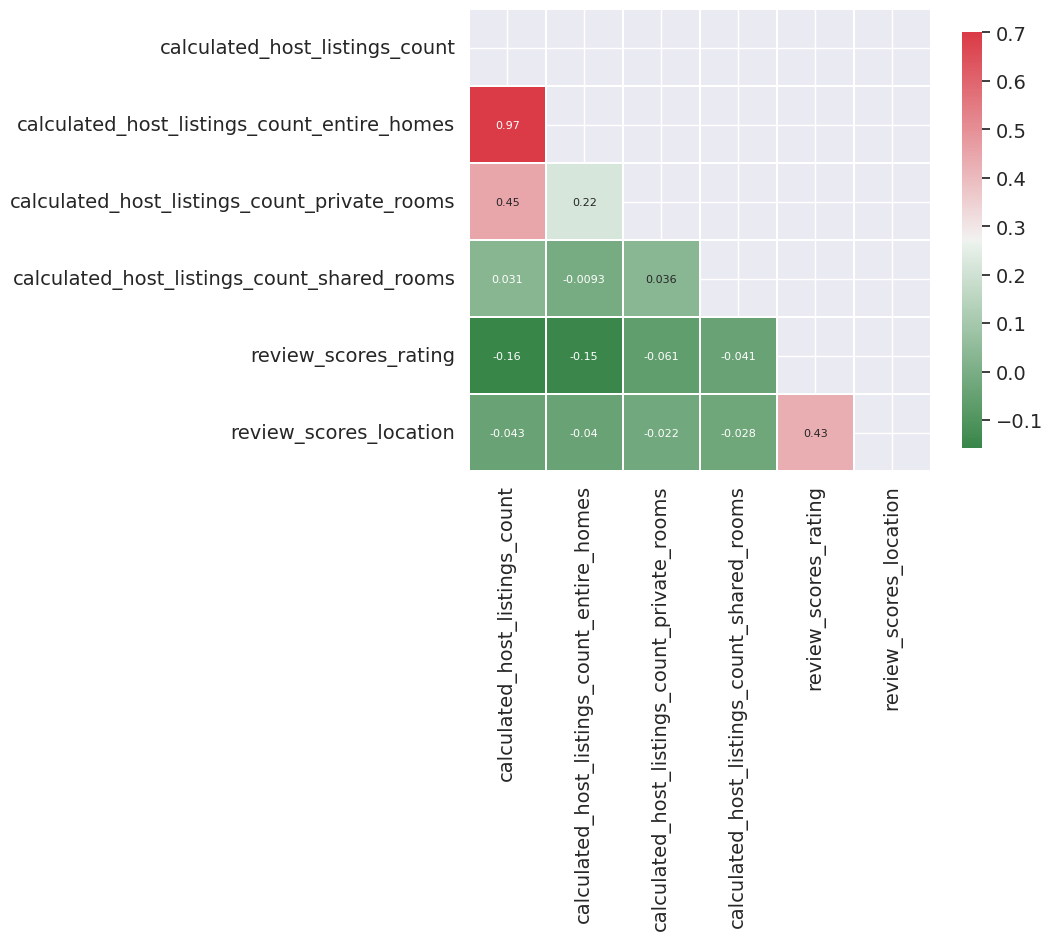

In [ ]:
# Correlation between the host listings and scores
mask = np.zeros_like(airbnb_pd[host_listings_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 6))           
sns.heatmap(airbnb_pd[host_listings_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

As we can see, the first two have a moderate negative correlation with the rating score. They are also highly (99%) correlated so it makes sense to delete one of the two. As I did with the price, I only leave the first one (calculated_host_listed_counts) that is kind of able to also represent the other features and I also remove the host_listings_count.

In [ ]:
# Drop some columns
airbnb_df = airbnb_df.drop('calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_total_listings_count')

In [ ]:
# Compute log(calculated_host_listings_count) to reduce the dimensionality of the column
airbnb_df = airbnb_df.withColumn('calculated_host_listings_count', log(airbnb_df['calculated_host_listings_count']))

Now, let's consider the amenities:

In [ ]:
# Define amenity features
amenity_features = ['has_internet', 'is_pet_friendly', 'is_children_friendly', 'has_cooking_basics', 'has_laundry', 'has_heating_cooling_systems', 'has_security_devices', 'has_fireplace', 'has_tv', 'is_long_term_stays_allowed', 'has_self_checkin', 'has_private_entrance', 'has_elevator', 'host_greets_you', 'has_free_parking', 'has_paid_parking', 'has_bathtub', 'has_patio', 'is_smoking_allowed', 'has_city_skyline_view', 'has_breakfast', 'review_scores_rating', 'review_scores_location']

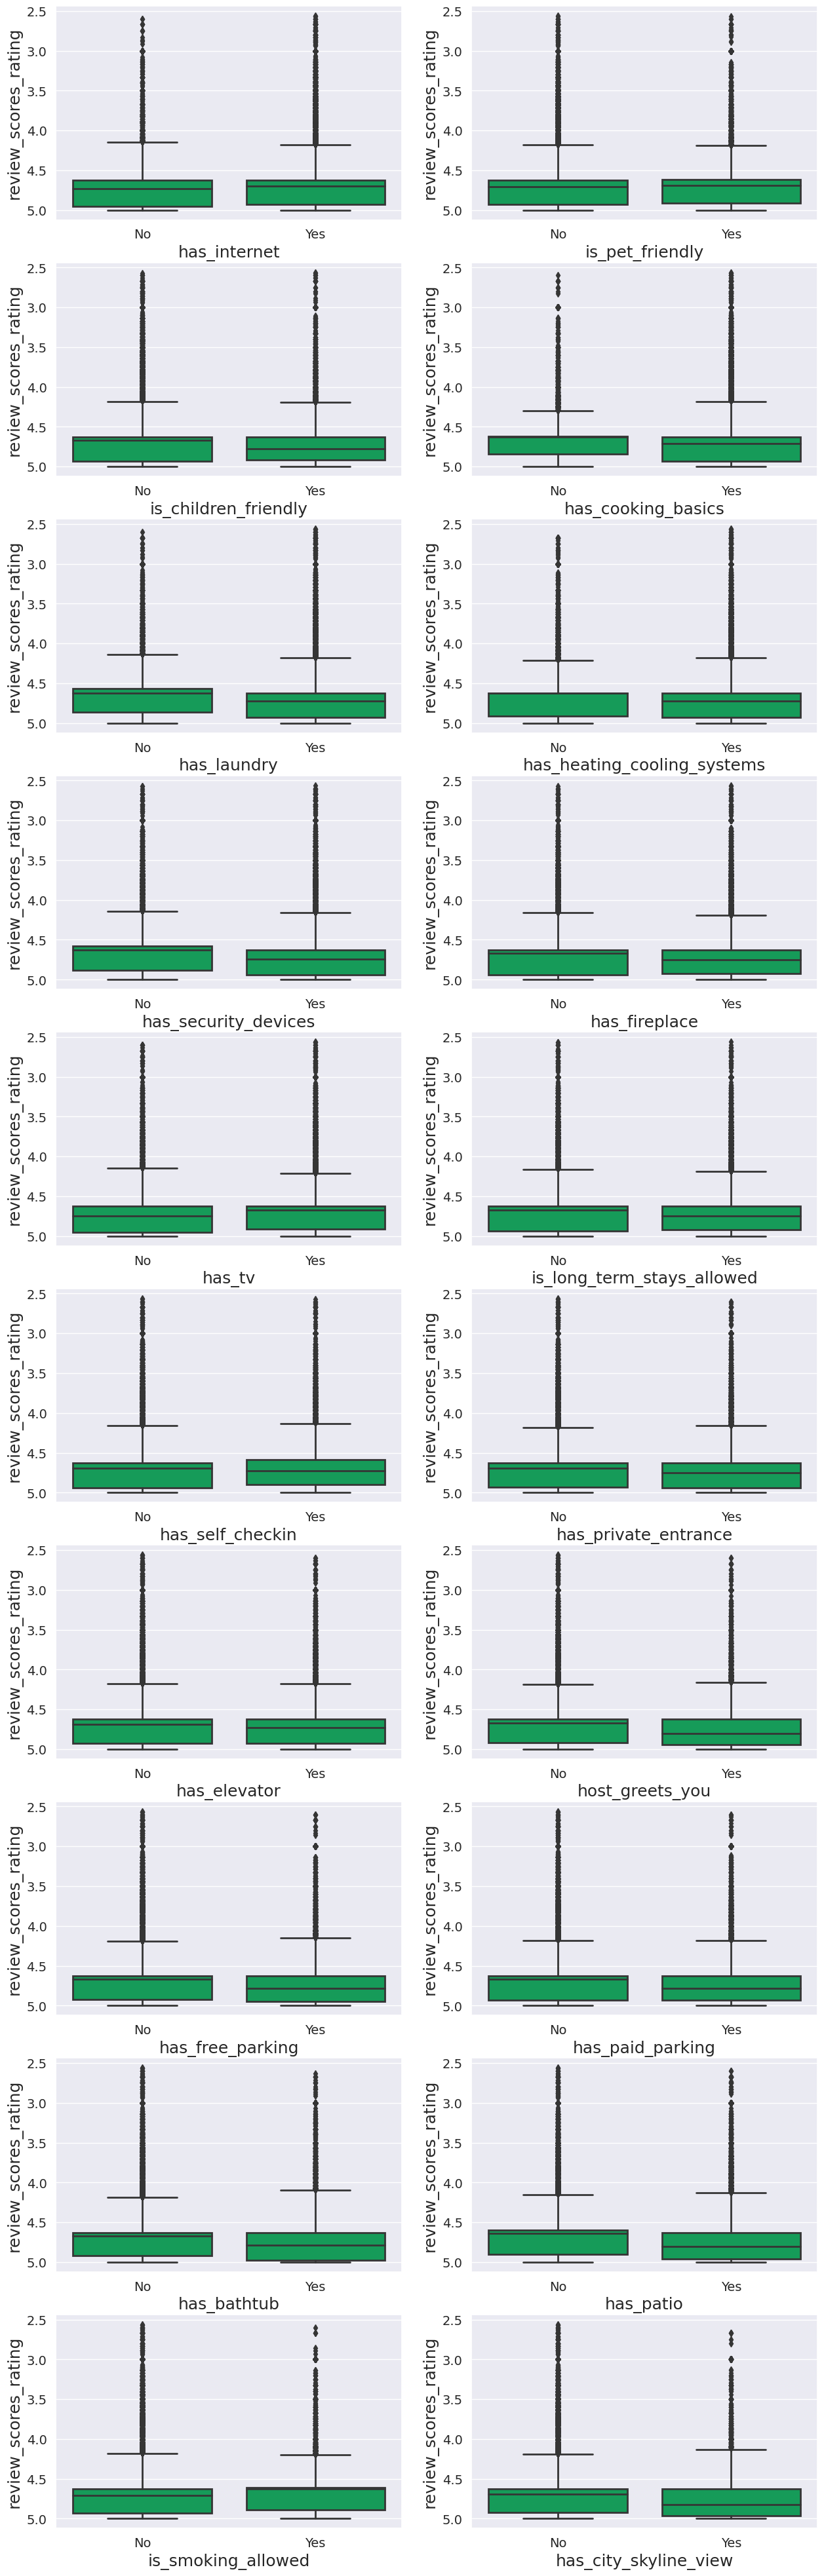

In [ ]:
# Visualize the variation of the rating score depending on the presence of a certain amenity of the Airbnb
n_rows = 10
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,50))
for i, f in enumerate(amenity_features[:-3]):
  _ = sns.boxplot(data = airbnb_pd, x = f, y = 'review_scores_rating', color ='#00b159', ax=axes[i//n_cols, i%n_cols]).invert_yaxis()
  axes[i//n_cols, i%n_cols].set_xticklabels(['No', 'Yes'])

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

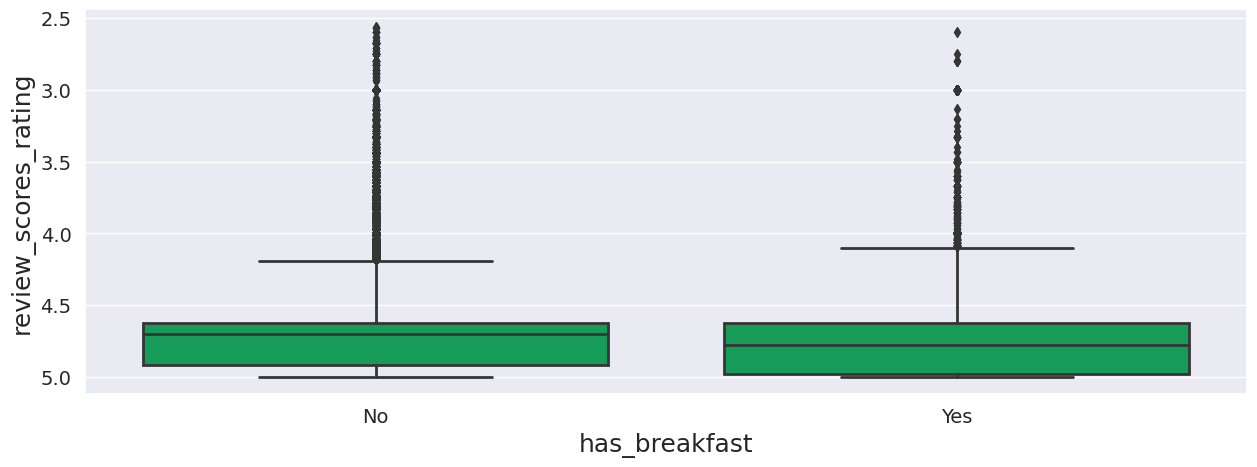

In [ ]:
# Visualize the variation of the rating score depending on the presence of a certain amenity of the Airbnb (breakfast)
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
_ = sns.boxplot(data = airbnb_pd, x = 'has_breakfast', y = 'review_scores_rating', color ='#00b159', ax=ax1).invert_yaxis()
ax1.set_xticklabels(['No', 'Yes'])

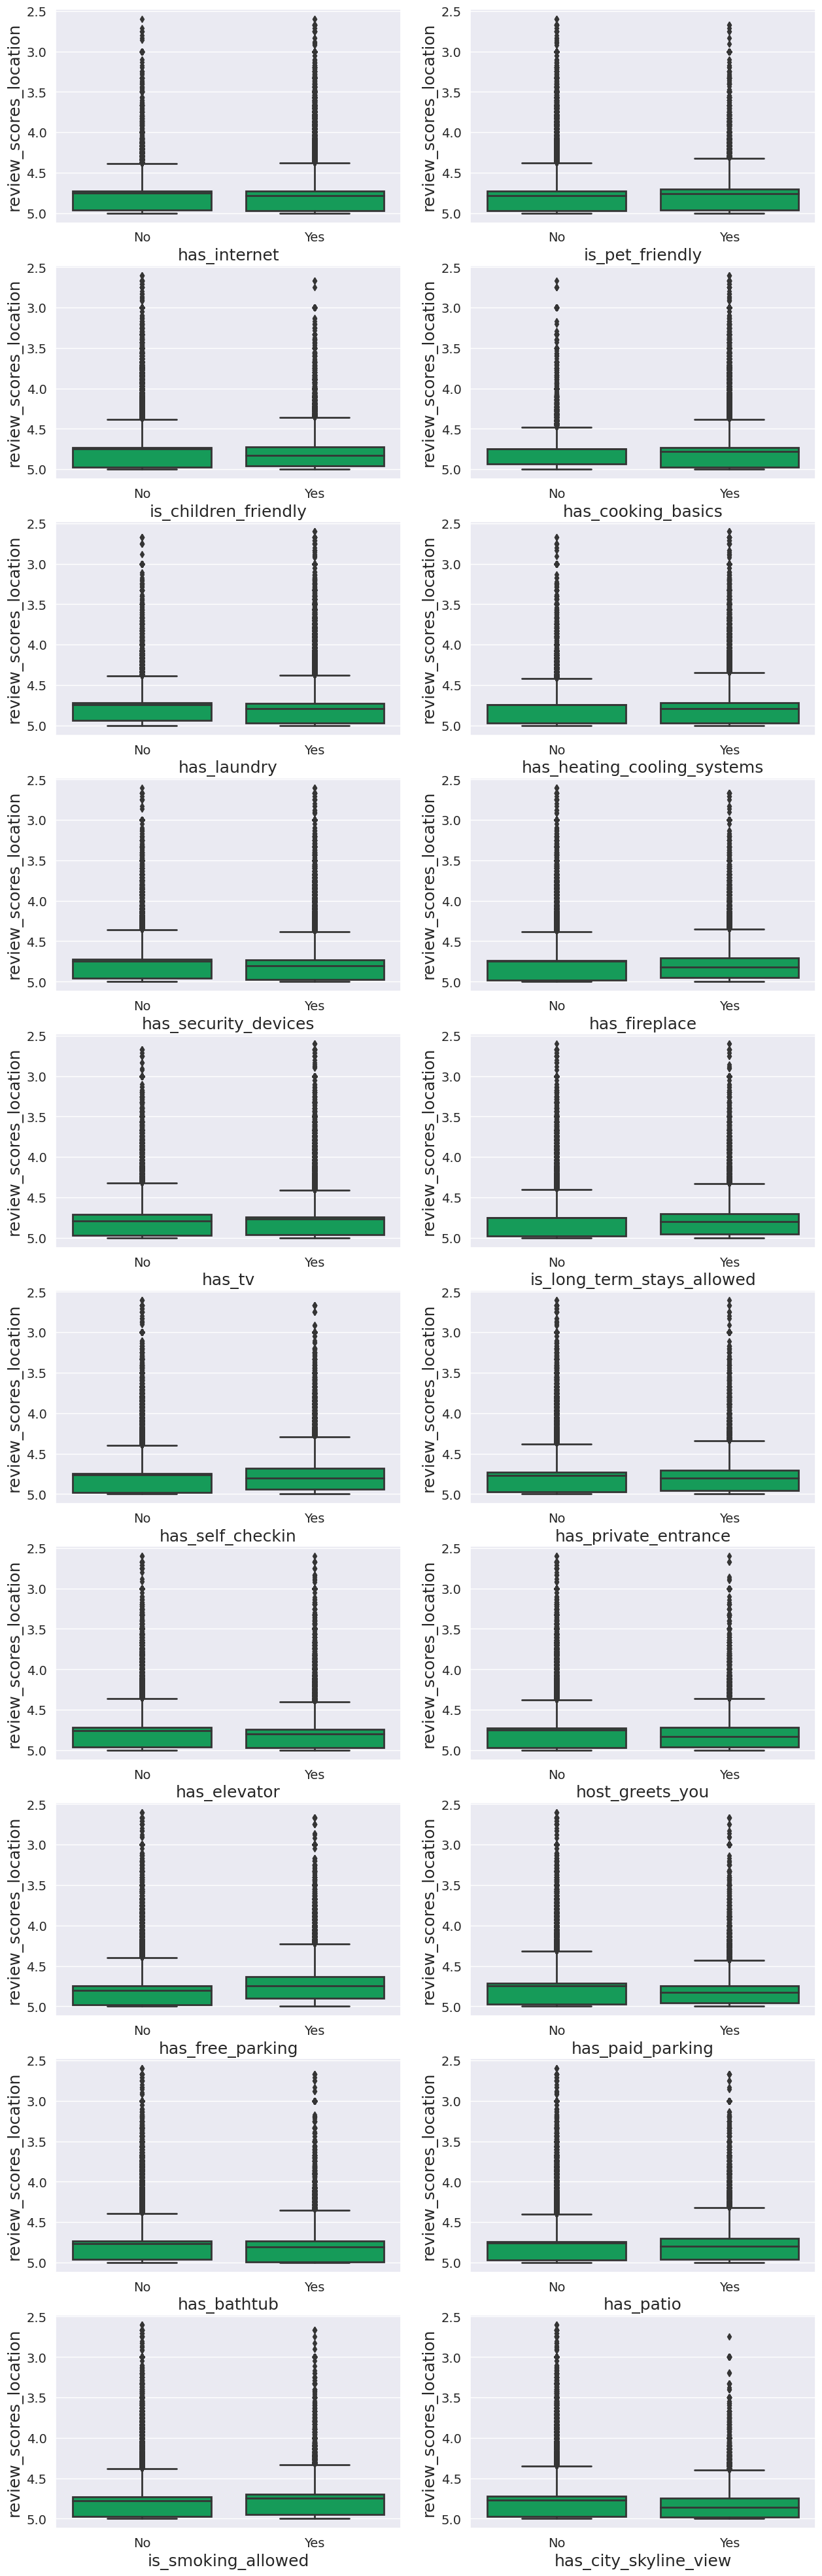

In [ ]:
# Visualize the variation of the location score depending on the presence of a certain amenity of the Airbnb
n_rows = 10
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,50))
for i, f in enumerate(amenity_features[:-3]):
  _ = sns.boxplot(data = airbnb_pd, x = f, y = 'review_scores_location', color ='#00b159', ax=axes[i//n_cols, i%n_cols]).invert_yaxis()
  axes[i//n_cols, i%n_cols].set_xticklabels(['No', 'Yes'])

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

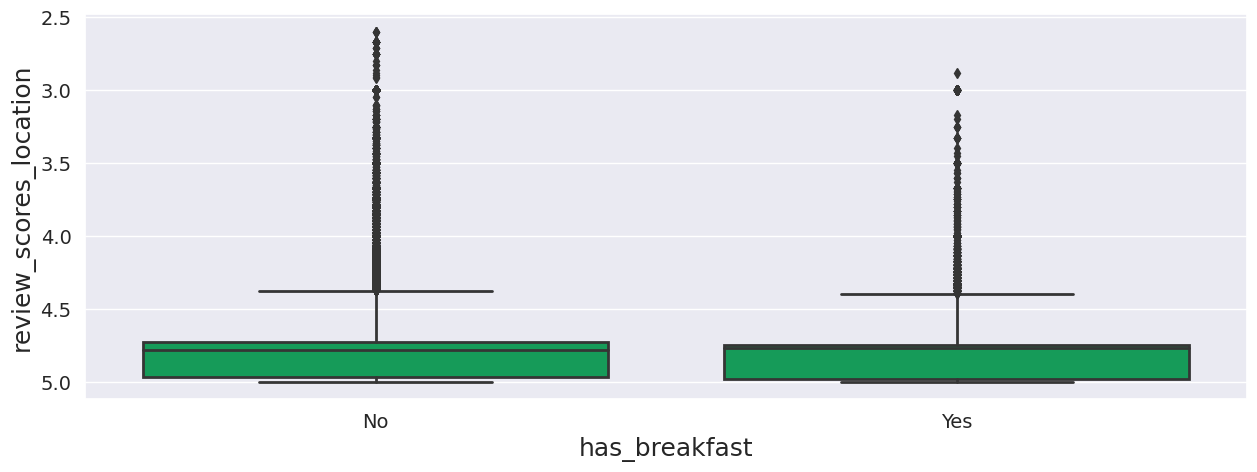

In [ ]:
# Visualize the variation of the location score depending on the presence of a certain amenity of the Airbnb (breakfast)
fig, (ax1) = plt.subplots(1, 1, figsize=(15,5))
_ = sns.boxplot(data = airbnb_pd, x = 'has_breakfast', y = 'review_scores_location', color ='#00b159', ax=ax1).invert_yaxis()
ax1.set_xticklabels(['No', 'Yes'])

<Axes: >

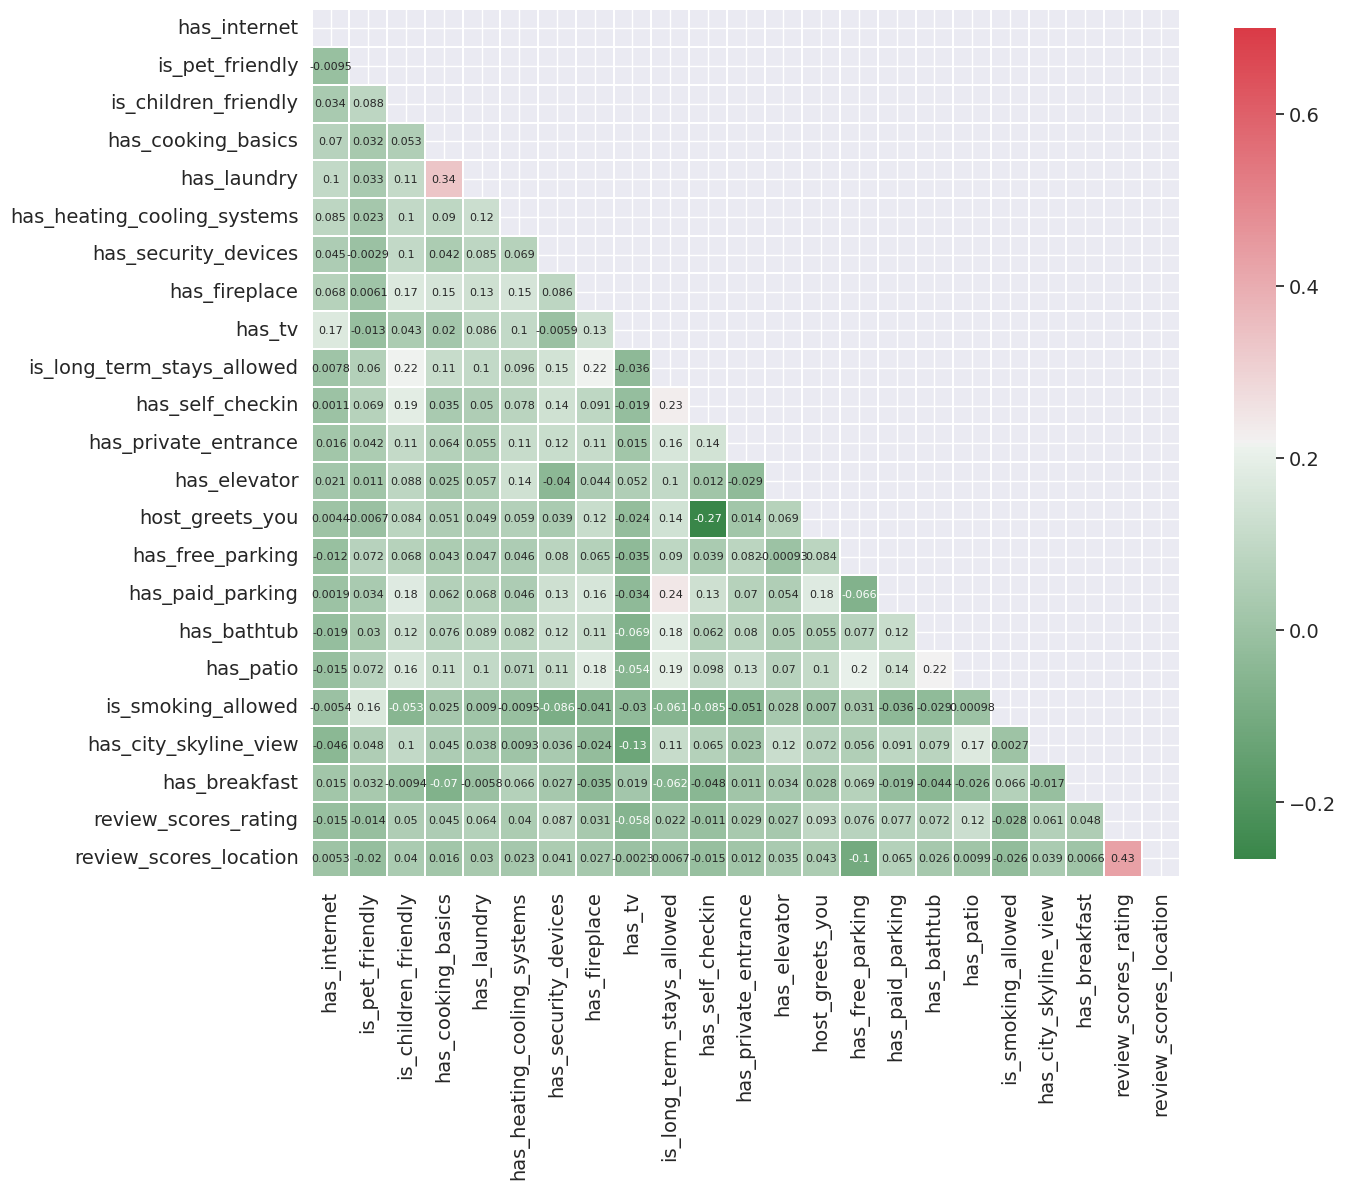

In [ ]:
# Correlation between the amenities and the scores
mask = np.zeros_like(airbnb_pd[amenity_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(14, 12))           
sns.heatmap(airbnb_pd[amenity_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

Some amenities help determine the rating score. It is possible to notice that if the accommodation has a patio, it has security devices, has a free or paid parking, a laundry, the city skylines view and offers breakfast the score slightly increases, while if smoking is allowed the score decreases. Concerning the location, there are no observations except for the fact that if there is no free parking, the location score decreases.

Finally, we do not consider the other scores since we want to try to make a prediction based only of the characteristics of the accommodation. For the moment we leave those features in order to make further tests and see what changes if we also consider those features:

In [ ]:
# Define the score features
scores_features = ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'review_scores_location', 'review_scores_rating']

<Axes: >

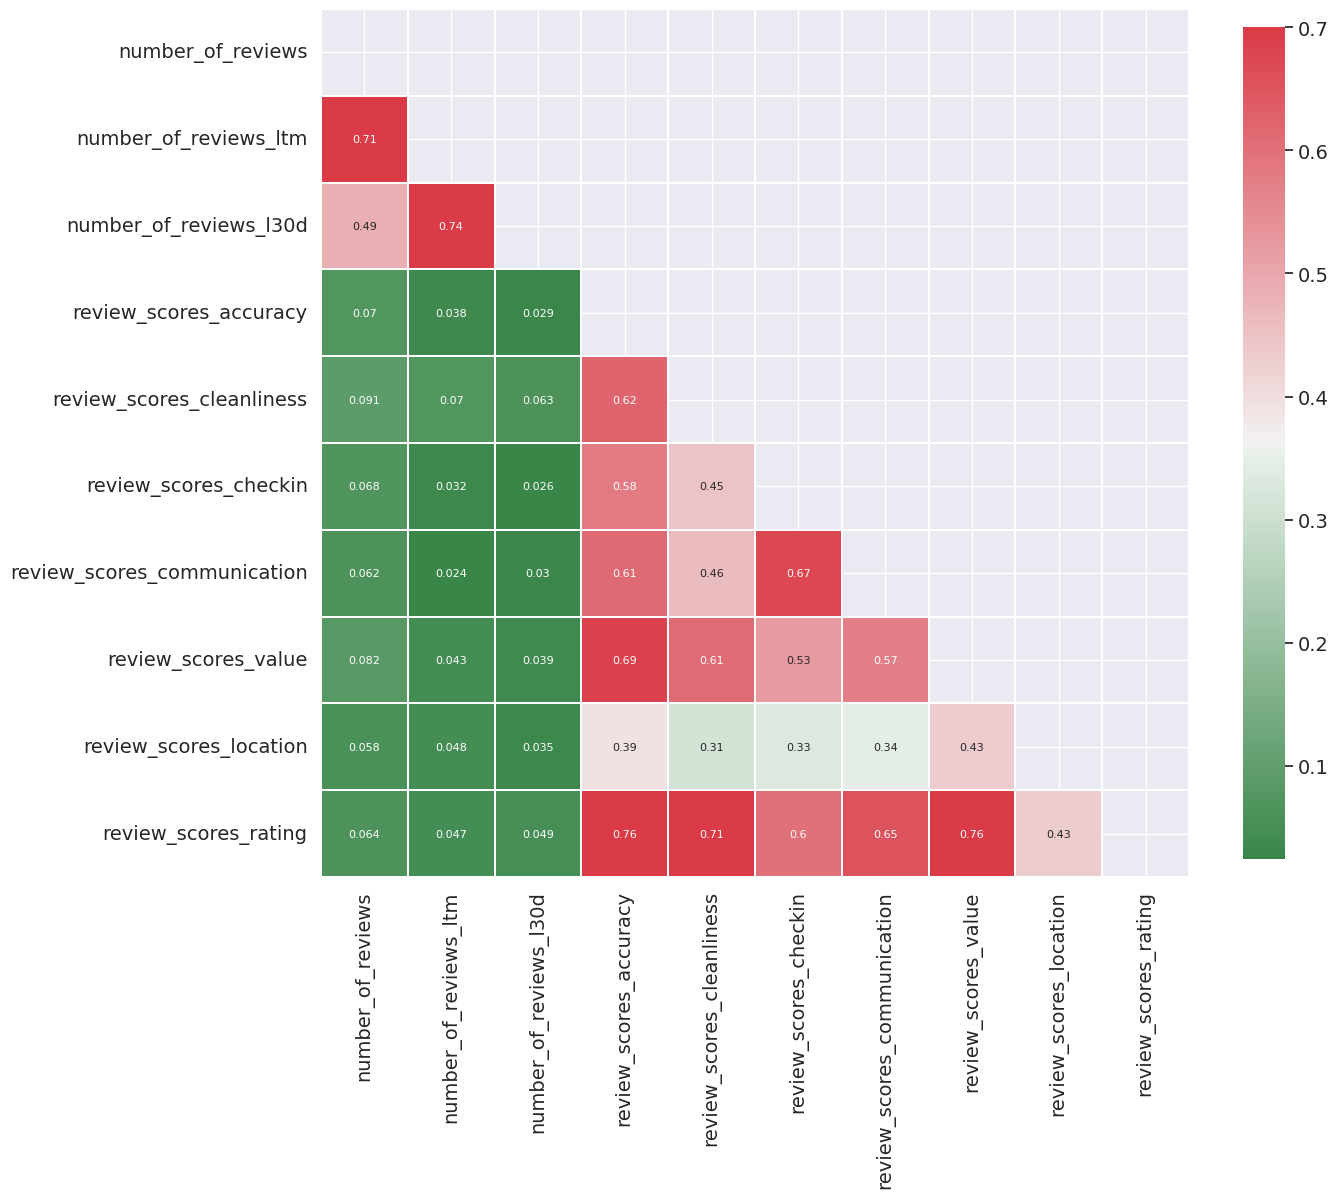

In [ ]:
# Correlation among the scores
mask = np.zeros_like(airbnb_pd[scores_features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(14, 12))           
sns.heatmap(airbnb_pd[scores_features].corr(),
            linewidths=0.25, 
            vmax=0.7, 
            square=True,
            ax=ax, 
            cmap=cmap, 
            linecolor='w', 
            annot=True, 
            annot_kws={"size":8}, 
            mask=mask, 
            cbar_kws={"shrink": .9})

In [ ]:
# Let's drop the price column since we don't consider it for determining the scores
airbnb_df = airbnb_df.drop('price')

In [ ]:
# Print the final cleaned dataset
airbnb_df.show()

+------------------+------------------+--------------------+-----------------+----------------------+----+---------+------------+--------+----+-------------------+-----------------+---------------------+----------------------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+----------------+------------------------------+-----------------+-----------------+----------------------+-----------+------------------+------------+---------------+--------------------+------------------+-----------+---------------------------+--------------------+-------------+------+--------------------------+----------------+--------------------+------------+---------------+----------------+----------------+-----------+---------+------------------+---------------------+-------------+-------------------+------------------+------------------+
|host_response_time|host_response_rate|host_acceptance_rat



---



Now, as we did with the price we manually analyzed what is the correlation between features and already removed some of them which are not particularly correlated with the scores. In order to make a better selection, let’s try some approaches. Let's first of all use a simple Filter-based Feature Selection using PySpark. This is based on Pearson Correlation so we shouldn't have a big difference with the previous approach:

In [ ]:
# Assemble the data to apply PySpark methods
assembler = VectorAssembler(inputCols=airbnb_df.columns, outputCol='features')
assembledData = assembler.transform(airbnb_df)

In [ ]:
# Compute the correlation matrix
correlationMatrix = Correlation.corr(assembledData, 'features').head()

In [ ]:
# Get the highest correlated features
features_correlations = correlationMatrix[0].toArray()
featureNames = airbnb_df.columns
labeledCorrelationsRating = sorted([(featureNames[i], str(features_correlations[i][14])) for i in range(len(featureNames))], key=lambda x: x[1], reverse=True)[1:]
labeledCorrelationsLocation = sorted([(featureNames[i], str(features_correlations[i][19])) for i in range(len(featureNames))], key=lambda x: x[1], reverse=True)[1:]

In [ ]:
# Print the results
print('Correlation between features and rating score:')
print(labeledCorrelationsRating)
print('Correlation between features and location score:')
print(labeledCorrelationsLocation)

Correlation between features and rating score:
[('review_scores_value', '0.7599004126443357'), ('review_scores_accuracy', '0.7576111280083067'), ('review_scores_cleanliness', '0.706980219772241'), ('review_scores_communication', '0.6533044808094876'), ('review_scores_checkin', '0.5980039059896932'), ('review_scores_location', '0.4309267605866337'), ('host_is_superhost', '0.24770125655994882'), ('has_patio', '0.12419140891399359'), ('host_greets_you', '0.09301724281029584'), ('has_security_devices', '0.08666822138000195'), ('has_paid_parking', '0.07703292763409288'), ('has_free_parking', '0.07620500652880258'), ('has_bathtub', '0.07208015664492022'), ('has_laundry', '0.06396141371282532'), ('number_of_reviews', '0.063692580502094'), ('has_city_skyline_view', '0.060974424645197735'), ('host_response_time', '0.05118928772747509'), ('is_email_verified', '0.051127326822424754'), ('is_children_friendly', '0.05030057226765105'), ('number_of_reviews_l30d', '0.04912201142571412'), ('has_breakfa

Let's see now the importance given by a Random Forest Regressor:

In [ ]:
# Split the data for training and testing the model
fs_train_data, fs_test_data = assembledData.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Define and train the model
fs_dt_rs = RandomForestRegressor(featuresCol='features', labelCol='review_scores_rating', numTrees=120, maxDepth=6)
fs_dt_rs_model = fs_dt_rs.fit(fs_train_data)

In [ ]:
# Get the feature importances
dt_rs_feature_importances = fs_dt_rs_model.featureImportances
rs_feature_importances = sorted([(airbnb_df.columns[i], dt_rs_feature_importances[i]) for i in range(len(airbnb_df.columns))], key=lambda x: x[1], reverse=True)[1:]

In [ ]:
# Print the importances given by the random tree
for feature, importance in rs_feature_importances:
  print(f"Feature: {feature}, Importance: {importance}")

Feature: review_scores_accuracy, Importance: 0.18127307909650742
Feature: review_scores_value, Importance: 0.12975401538775574
Feature: review_scores_cleanliness, Importance: 0.055949457981941224
Feature: review_scores_communication, Importance: 0.04770605848100516
Feature: review_scores_checkin, Importance: 0.029211758086798968
Feature: number_of_reviews, Importance: 0.015231798121019855
Feature: review_scores_location, Importance: 0.005425630920907265
Feature: host_is_superhost, Importance: 0.002828236250068078
Feature: number_of_reviews_ltm, Importance: 0.002330509511438883
Feature: calculated_host_listings_count, Importance: 0.0005780258010249948
Feature: has_patio, Importance: 0.0002683823289480247
Feature: number_of_reviews_l30d, Importance: 4.274521783582286e-05
Feature: host_response_time, Importance: 3.814184616595532e-05
Feature: has_bathtub, Importance: 3.1731104721366986e-05
Feature: host_acceptance_rate, Importance: 3.0433885600278916e-05
Feature: host_response_rate, Impor

Both methods highlighted that some features are used more than others. We'll keep that into consideration when training the model. Notice that the most correlated features are the other scores but we won't consider them during the model creation as already stated above.


In [ ]:
# Define and train the model
fs_dt_ls = RandomForestRegressor(featuresCol='features', labelCol='review_scores_location', numTrees=120, maxDepth=6)
fs_dt_ls_model = fs_dt_ls.fit(fs_train_data)

In [ ]:
# Get most important features
dt_ls_feature_importances = fs_dt_ls_model.featureImportances
ls_feature_importances = sorted([(airbnb_df.columns[i], dt_ls_feature_importances[i]) for i in range(len(airbnb_df.columns))], key=lambda x: x[1], reverse=True)[1:]

In [ ]:
# Print the importances given by the random tree
for feature, importance in ls_feature_importances:
  print(f"Feature: {feature}, Importance: {importance}")

Feature: review_scores_value, Importance: 0.06892474159894456
Feature: review_scores_rating, Importance: 0.044875941642218614
Feature: review_scores_accuracy, Importance: 0.033241930996798355
Feature: number_of_reviews, Importance: 0.0250941985415162
Feature: review_scores_communication, Importance: 0.01798984346873757
Feature: poi_dist, Importance: 0.01580062669705229
Feature: review_scores_checkin, Importance: 0.014133875201093158
Feature: city_center_dist, Importance: 0.007088082587048346
Feature: station_dist, Importance: 0.003134451517357188
Feature: review_scores_cleanliness, Importance: 0.002809172831444997
Feature: number_of_reviews_ltm, Importance: 0.0021196409972279243
Feature: city, Importance: 0.0013013178837842825
Feature: has_free_parking, Importance: 0.0009460070122879668
Feature: host_acceptance_rate, Importance: 7.36584536777894e-05
Feature: number_of_reviews_l30d, Importance: 6.7992199891271e-05
Feature: host_is_superhost, Importance: 5.4150835767319245e-05
Feature: c

In [ ]:
# Save the cleaned dataset (remove the comment if you want to save the dataset)
# airbnb_df.coalesce(1).write.mode('overwrite').csv(GDRIVE_DATA_DIR + '/airbnb_cleaned_df_score_models.csv')

# 6.2 Training the Model

In order to train the model, we'll try several approaches. First we try to understand what are the features that give the best results, then we try different models to understand what gives the best result while also doing some hyperparameters tuning. We'll do it both for the rating score and the location score.

In [ ]:
# Function that create a simple lr model (with no hyperparameter tuning)
def simple_linear_regression_model(train, featureCol, labelCol):
  lr = LinearRegression(featuresCol=featureCol, labelCol=labelCol)
  lr_model = lr.fit(train)
  return lr_model

In [ ]:
# Function that create a simple rf model (with no hyperparameter tuning)
def simple_random_forest_model(train, featureCol, labelCol):
  rf = RandomForestRegressor(featuresCol=featureCol, labelCol=labelCol)
  rf_model = rf.fit(train)
  return rf_model

In [ ]:
# Function that create a simple gbt model (with no hyperparameter tuning)
def simple_gbt_model(train, featureCol, labelCol):
  gbt = GBTRegressor(featuresCol=featureCol, labelCol=labelCol)
  gbt_model = gbt.fit(train)
  return gbt_model

In [ ]:
# Define the evaluation metrics
metrics = ['mse', 'rmse', 'mae', 'r2']

In [ ]:
# Function to compute the r2 adjusted metric
# r2 is the r2 metric, n is the number of observations, k is the number of features
def compute_r2adj(r2, n, k):
  return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

In [ ]:
# Function to evaluate a model
def evaluate_models(predictions, modelName, typeName, label, prediction, metrics):
  r2 = None
  for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=label, predictionCol=prediction, metricName=metric) 
    evaluation = evaluator.evaluate(predictions)
    print(metric.upper()+' for '+modelName+' on '+typeName+' set: '+str(evaluation))
    if metric == 'r2':
      print('R2_adj'+' for '+modelName+' on '+typeName+' set: '+str(compute_r2adj(evaluation, predictions.count(), len(predictions.columns))))

In [ ]:
# Function that create simple models (without hyperparameter tuning) and evaluate them
def test_best_features(df, features, featureCol, labelCol, metrics = ['rmse', 'r2']):
  assembler = VectorAssembler(inputCols=features, outputCol=featureCol)
  assembled_data = assembler.transform(df).select([featureCol, labelCol])
  train_data, test_data = assembled_data.randomSplit([0.80, 0.20], seed=0)

  # Train the models
  lr = simple_linear_regression_model(train_data, featureCol, labelCol)
  rf = simple_random_forest_model(train_data, featureCol, labelCol)
  gbt = simple_gbt_model(train_data, featureCol, labelCol)

  # Training set evaluation
  lr_training = lr.transform(train_data)
  evaluate_models(lr_training, 'linear regression', 'training', labelCol, 'prediction', metrics)
  rf_training = rf.transform(test_data)
  evaluate_models(rf_training, 'random forest regression', 'training', labelCol, 'prediction', metrics)
  gbt_training = gbt.transform(train_data)
  evaluate_models(gbt_training, 'gradient boosted tree regression', 'training', labelCol, 'prediction', metrics)

  # Testing set evaluation
  lr_predictions = lr.transform(test_data)
  evaluate_models(lr_predictions, 'linear regression', 'testing', labelCol, 'prediction', metrics)
  rf_predictions = rf.transform(test_data)
  evaluate_models(rf_predictions, 'random forest regression', 'testing', labelCol, 'prediction', metrics)
  gbt_predictions = gbt.transform(test_data)
  evaluate_models(gbt_predictions, 'gradient boosted tree regression', 'testing', labelCol, 'prediction', metrics)

### Review score rating prediction model

In order to train the model, we'll try several approaches. First we try to understand what are the features that give the best results, then we try different models to understand what gives the best result while also doing some hyperparameters tuning. Let's see what features give the best results based on the information we got so far. I train some simple model (without hyperparameter tuning) to see what are the results with different features:

In [ ]:
# Consider the most relevant features
most_relevant_features_rs = ['host_is_superhost', 'has_patio', 'has_security_devices', 'host_greets_you', 'has_free_parking']

In [ ]:
# Test performances with the most relevant features
test_best_features(airbnb_df, most_relevant_features_rs, 'features', 'review_scores_rating')

RMSE for linear regression on training set: 0.30727829782458144
R2 for linear regression on training set: 0.07633656446766313
R2_adj for linear regression on training set: 0.07632457449623575
RMSE for random forest regression on training set: 0.3048952263390428
R2 for random forest regression on training set: 0.07867697302235055
R2_adj for random forest regression on training set: 0.07862956360415274
RMSE for gradient boosted tree regression on training set: 0.306849190598213
R2 for gradient boosted tree regression on training set: 0.07891451357984758
R2_adj for gradient boosted tree regression on training set: 0.07890255707248839
RMSE for linear regression on testing set: 0.30487479710649806
R2 for linear regression on testing set: 0.07880043374044632
R2_adj for linear regression on testing set: 0.07875303067528716
RMSE for random forest regression on testing set: 0.3048952263390428
R2 for random forest regression on testing set: 0.07867697302235055
R2_adj for random forest regression

In [ ]:
# Consider less relevant features (moderate positive or negative correlation)
mid_relevant_features_rs = ['calculated_host_listings_count', 'host_is_superhost', 'instant_bookable', 'has_patio', 'host_greets_you', 'has_security_devices', 'has_paid_parking', 'has_free_parking', 'poi_dist', 'host_response_rate', 'availability_365', 'host_acceptance_rate', 'host_response_time', 'station_dist', 'has_fireplace', 'city', 'is_children_friendly', 'has_bathtub', 'has_breakfast', 'has_cooking_basics', 'has_tv', 'is_smoking_allowed', 'accommodates', 'is_email_verified', 'is_phone_verified', 'is_work_email_verified', 'is_bathroom_shared']

In [ ]:
# Test features with the less relevant features 
test_best_features(airbnb_df, mid_relevant_features_rs, 'features', 'review_scores_rating')

RMSE for linear regression on training set: 0.2960772995078172
R2 for linear regression on training set: 0.13949622215872948
R2_adj for linear regression on training set: 0.13948505205573247
RMSE for random forest regression on training set: 0.29757433019429924
R2 for random forest regression on training set: 0.13431605071042962
R2_adj for random forest regression on training set: 0.13427150436655544
RMSE for gradient boosted tree regression on training set: 0.29224306691254626
R2 for gradient boosted tree regression on training set: 0.16163914248117717
R2_adj for gradient boosted tree regression on training set: 0.1616282598129446
RMSE for linear regression on testing set: 0.29691055771779323
R2 for linear regression on testing set: 0.1381737511035449
R2_adj for linear regression on testing set: 0.13812940326912482
RMSE for random forest regression on testing set: 0.29757433019429924
R2 for random forest regression on testing set: 0.13431605071042962
R2_adj for random forest regressio

In [ ]:
# Consider all features (excpet the ones we removed before and the other scores)
all_features_rs = airbnb_df.drop('number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'review_scores_rating', 'review_scores_location').columns

In [ ]:
# Test features with all features (excpet the ones we removed before and the other scores)
test_best_features(airbnb_df, all_features_rs, 'features', 'review_scores_rating')

RMSE for linear regression on training set: 0.2960091480012193
R2 for linear regression on training set: 0.1425554028500795
R2_adj for linear regression on training set: 0.14254427245796386
RMSE for random forest regression on training set: 0.29466893624250706
R2 for random forest regression on training set: 0.14060198006186297
R2_adj for random forest regression on training set: 0.1405577571791904
RMSE for gradient boosted tree regression on training set: 0.29237704193277614
R2 for gradient boosted tree regression on training set: 0.16346842492629743
R2_adj for gradient boosted tree regression on training set: 0.16345756600377503
RMSE for linear regression on testing set: 0.2933682440676525
R2 for linear regression on testing set: 0.1481721382033061
R2_adj for linear regression on testing set: 0.14812830486564932
RMSE for random forest regression on testing set: 0.29466893624250706
R2 for random forest regression on testing set: 0.14060198006186297
R2_adj for random forest regression 

For the tests done so far, it is possible to notice how the performances are always low. This is due to the fact that the features considered are not able to describe the rating score. As we can see, the RMSE is too high considering that the variability of the score is low. Let's try to select the best model with hyperparameter tuning and the, we'll make further tests.


In [ ]:
# Let's again split the data (here we also use validation data to find the best hyperparameters)
# I take the second group (less relevant features) since it gives the best results
assembler = VectorAssembler(inputCols=mid_relevant_features_rs, outputCol='features')
assembled_data = assembler.transform(airbnb_df).select(['features', 'review_scores_rating'])
train_data, test_data, validation_data = assembled_data.randomSplit([0.80, 0.15, 0.05], seed=0)

In [ ]:
# Hyperparameter tuning for linear regression
def linear_regression_cross_val(train, labelCol, k_fold=5):
    lr = LinearRegression(featuresCol='features', labelCol=labelCol)
    pipeline = Pipeline(stages=[lr])

    param_grid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(labelCol=labelCol),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
# Execute cross validation with linear regression
cv_lr_models_rs = linear_regression_cross_val(validation_data, 'review_scores_rating')

In [ ]:
# Summarizes all the models trained during cross validation
def summarize_lr_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: lambda=[{:.3f}]; alpha=[{:.3f}] ".format(m.stages[-1]._java_obj.getRegParam(), m.stages[-1]._java_obj.getElasticNetParam()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above|
summarize_lr_models(cv_lr_models_rs.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_3fa76cd39be5, numFeatures=27

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_3fa76cd39be5, numFeatures=27

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_3fa76cd39be5, numFeatures=27

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_3fa76cd39be5, numFeatures=27

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_3fa76cd39be5, numFeatures=27

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_3fa76cd39be5, numFeatures=27


In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_lr_models_rs.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.296388
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.296388
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.296388
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.296620
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.302761
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.309411
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.297233
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.310606
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.320230


In [ ]:
# Get the best model to extract best hyperparameters
best_lr_model_params = cv_lr_models_rs.bestModel.stages[-1].extractParamMap()
print("Best parameters for linear regression:")
for param, value in best_lr_model_params.items():
    print(param.name, "=", value)

Best parameters for linear regression:
aggregationDepth = 2
elasticNetParam = 0.0
epsilon = 1.35
featuresCol = features
fitIntercept = True
labelCol = review_scores_rating
loss = squaredError
maxBlockSizeInMB = 0.0
maxIter = 100
predictionCol = prediction
regParam = 0.0
solver = auto
standardization = True
tol = 1e-06


In [ ]:
# Fit a model with best parameters using training test
lr_rs = LinearRegression(featuresCol='features', labelCol='review_scores_rating', elasticNetParam=0.0, regParam=0.0, maxIter=1000)
lr_model_rs = lr_rs.fit(train_data)

In [ ]:
# Training set evaluation
lr_training_rs = lr_model_rs.transform(train_data)
evaluate_models(lr_training_rs, 'linear regression', 'training', 'review_scores_rating', 'prediction', metrics)

# Testing set evaluation
lr_predictions_rs = lr_model_rs.transform(test_data)
evaluate_models(lr_predictions_rs, 'linear regression', 'testing', 'review_scores_rating', 'prediction', metrics)

MSE for linear regression on training set: 0.08766176728384167
RMSE for linear regression on training set: 0.2960772995078172
MAE for linear regression on training set: 0.1995544485537103
R2 for linear regression on training set: 0.13949622215872948
R2_adj for linear regression on training set: 0.13948505205573247
MSE for linear regression on testing set: 0.08825597552679555
RMSE for linear regression on testing set: 0.29707907285232255
MAE for linear regression on testing set: 0.2002250335704628
R2 for linear regression on testing set: 0.1364928636060968
R2_adj for linear regression on testing set: 0.1364332318808268


In [ ]:
# Save the LR best model
lr_model_rs.write().overwrite().save(GDRIVE_DATA_DIR + '/models/rating_score/LinearRegressor')



---



In [ ]:
# Hyperparameter tuning for random forest regressor
def rf_cross_val(train, labelCol, k_fold=5):
    rf = RandomForestRegressor(featuresCol='features', labelCol=labelCol)
    pipeline = Pipeline(stages=[rf])

    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [7, 8, 9]) \
    .addGrid(rf.numTrees, [40, 60, 80]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(labelCol=labelCol),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
# Execute cross validation with random forest regressor (high RAM usage!)
cv_rf_models_rs = rf_cross_val(validation_data, 'review_scores_rating')

In [ ]:
# Summarizes all the models trained during k-fold cross validation
def summarize_rf_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDepth=[{:.3f}]; numTrees=[{:.3f}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getNumTrees()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above
summarize_rf_models(cv_rf_models_rs.subModels)

NameError: ignored

In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_rf_models_rs.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.295393
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.295085
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.295177
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.294979
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.294595
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.294693
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.294902
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.294376
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.294423


In [ ]:
# Get the best model to extract best hyperparameters
best_rf_model_params_rs = cv_rf_models_rs.bestModel.stages[-1].extractParamMap()
print('Best parameters for random forest regressor:')
for param, value in best_rf_model_params_rs.items():
    print(param.name, "=", value)

Best parameters for random forest regressor:
bootstrap = True
cacheNodeIds = False
checkpointInterval = 10
featureSubsetStrategy = auto
featuresCol = features
impurity = variance
labelCol = review_scores_rating
leafCol = 
maxBins = 32
maxDepth = 9
maxMemoryInMB = 256
minInfoGain = 0.0
minInstancesPerNode = 1
minWeightFractionPerNode = 0.0
numTrees = 60
predictionCol = prediction
seed = 426645657202394545
subsamplingRate = 1.0


In [ ]:
# Fit a model with best parameters
rf_rs = RandomForestRegressor(featuresCol='features', labelCol='review_scores_rating', maxDepth=9, numTrees=60)
rf_model_rs = rf_rs.fit(train_data)

In [ ]:
# Training set evaluation
rf_training_rs = rf_model_rs.transform(train_data)
evaluate_models(rf_training_rs, 'random forest regressor', 'training', 'review_scores_rating', 'prediction', metrics)

# Testing set evaluation
rf_predictions_rs = rf_model_rs.transform(test_data)
evaluate_models(rf_predictions_rs, 'random forest regressor', 'testing', 'review_scores_rating', 'prediction', metrics)

MSE for random forest regressor on training set: 0.08427869470530525
RMSE for random forest regressor on training set: 0.2903079308343216
MAE for random forest regressor on training set: 0.194183001940712
R2 for random forest regressor on training set: 0.1727050750571173
R2_adj for random forest regressor on training set: 0.172694336034514
MSE for random forest regressor on testing set: 0.08622627702467309
RMSE for random forest regressor on testing set: 0.29364311165881807
MAE for random forest regressor on testing set: 0.19632309833731257
R2 for random forest regressor on testing set: 0.156351679180331
R2_adj for random forest regressor on testing set: 0.1562934188570848


In [ ]:
# Save the RF best model
rf_model_rs.write().overwrite().save(GDRIVE_DATA_DIR + '/models/rating_score/RandomForestRegressor')



---



In [ ]:
# Hyperparameter tuning for gradient-boosted trees
def gbt_cross_val(train, labelCol, k_fold=5):
    gbt = GBTRegressor(featuresCol='features', labelCol=labelCol)
    pipeline = Pipeline(stages=[gbt])

    param_grid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [6, 7, 8]) \
    .addGrid(gbt.maxIter, [11, 12, 13]) \
    .addGrid(gbt.stepSize, [0.15, 0.2, 0.25]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(labelCol=labelCol),
                               numFolds=k_fold,
                               collectSubModels=True
                               )

    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
# Execute cross validation with gradient-boosted trees
cv_gbt_models_rs = gbt_cross_val(validation_data, 'review_scores_rating')

In [ ]:
# Summarizes all the models trained during k-fold cross validation
def summarize_gbt_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: maxDepth=[{:.3f}]; maxIter=[{:.3f}; stepSize=[{:.3f}] ".format(m.stages[-1]._java_obj.getMaxDepth(), m.stages[-1]._java_obj.getMaxIter(), m.stages[-1]._java_obj.getStepSize()))
            print("\tModel summary: {}\n".format(m.stages[-1]))
        print("***************************************\n")

In [ ]:
# Call the function above maxDepth=7, maxIter=13, stepSize=0.2
summarize_gbt_models(cv_gbt_models_rs.subModels)

*************** Fold #1 ***************

--- Model #1 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.150] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_18887a20f630, numTrees=11, numFeatures=27

--- Model #2 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.200] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_18887a20f630, numTrees=11, numFeatures=27

--- Model #3 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.250] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_18887a20f630, numTrees=11, numFeatures=27

--- Model #4 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[12.000; stepSize=[0.150] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_18887a20f630, numTrees=12, numFeatures=27

--- Model #5 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[12.000; stepSize=[0.200] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_18887a20f630, numTrees=12, numFeatures=27

--- Model #6 o

In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_gbt_models_rs.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.302890
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.304116
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.307887
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.303100
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.304494
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.308424
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.303363
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.304688
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.309274
Avg. RMSE computed across k-fold cross validation for model setting #10: 0.309973
Avg. RMSE computed across k-fold cross validation for model setting #11: 0.313380
Avg. RMSE computed across k-fold cross validation for model setting #12: 0.318291
Avg. RMSE computed across

In [ ]:
# Get the best model to extract best hyperparameters
best_gbt_model_params_rs = cv_gbt_models_rs.bestModel.stages[-1].extractParamMap()
print("Best parameters for gradient-boosted trees:")
for param, value in best_gbt_model_params_rs.items():
    print(param.name, "=", value)

Best parameters for gradient-boosted trees:
cacheNodeIds = False
checkpointInterval = 10
featureSubsetStrategy = all
featuresCol = features
impurity = variance
labelCol = review_scores_rating
leafCol = 
lossType = squared
maxBins = 32
maxDepth = 6
maxIter = 11
maxMemoryInMB = 256
minInfoGain = 0.0
minInstancesPerNode = 1
minWeightFractionPerNode = 0.0
predictionCol = prediction
seed = -7140245879972423352
stepSize = 0.15
subsamplingRate = 1.0
validationTol = 0.01


In [ ]:
# Fit a model with best parameters
gbt_rs = GBTRegressor(featuresCol='features', labelCol='review_scores_rating', maxDepth=6, maxIter=11, stepSize=0.15)
gbt_model_rs = gbt_rs.fit(train_data)

In [ ]:
# Training set evaluation
gbt_training_rs = gbt_model_rs.transform(train_data)
evaluate_models(gbt_training_rs, 'gradient-boosted tree regressor', 'training', 'review_scores_rating', 'prediction', metrics)

# Testing set evaluation
gbt_predictions_rs = gbt_model_rs.transform(test_data)
evaluate_models(gbt_predictions_rs, 'gradient-boosted tree regressor', 'testing', 'review_scores_rating', 'prediction', metrics)

MSE for gradient-boosted tree regressor on training set: 0.08478022314916894
RMSE for gradient-boosted tree regressor on training set: 0.2911704365988569
MAE for gradient-boosted tree regressor on training set: 0.1955587093203146
R2 for gradient-boosted tree regressor on training set: 0.16778198105603248
R2_adj for gradient-boosted tree regressor on training set: 0.16777117812729825
MSE for gradient-boosted tree regressor on testing set: 0.08610420045756526
RMSE for gradient-boosted tree regressor on testing set: 0.2934351724956728
MAE for gradient-boosted tree regressor on testing set: 0.1972064708057932
R2 for gradient-boosted tree regressor on testing set: 0.15754609107431183
R2_adj for gradient-boosted tree regressor on testing set: 0.15748791323427735


In [ ]:
# Save the GBT best model for further use (we'll use this one in the real test scenarios)
gbt_model_rs.write().overwrite().save(GDRIVE_DATA_DIR + '/models/rating_score/GradientBoostedRegressor')

So far, we saw that the performances are really low. Again, this is due to the fact that there are no features that are able to describe the rating scores given by the guests. The only features that are really relevant are the other scores. Let's now make a test and fit a model also including those features to see if something changes:

In [ ]:
# Define the list features we considered before plus the other scores
test_features_rs = mid_relevant_features_rs+['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'review_scores_location']

In [ ]:
# Define the training and testing sets
assembler_test_rs = VectorAssembler(inputCols=test_features_rs, outputCol='features')
assembled_data_test_rs = assembler_test_rs.transform(airbnb_df).select(['features', 'review_scores_rating'])
train_data_test_rs, test_data_test_rs = assembled_data_test_rs.randomSplit([0.80, 0.20], seed=0)

In [ ]:
# Fit a model with best parameters
gbt_test_rs = GBTRegressor(featuresCol='features', labelCol='review_scores_rating', maxDepth=6, maxIter=11, stepSize=0.15)
gbt_model_test_rs = gbt_test_rs.fit(train_data_test_rs)

In [ ]:
# Training set evaluation
gbt_training_test_rs = gbt_model_test_rs.transform(train_data_test_rs)
evaluate_models(gbt_training_test_rs, 'gradient-boosted tree regressor', 'training', 'review_scores_rating', 'prediction', metrics)

# Testing set evaluation
gbt_predictions_test_rs = gbt_model_test_rs.transform(test_data_test_rs)
evaluate_models(gbt_predictions_test_rs, 'gradient-boosted tree regressor', 'testing', 'review_scores_rating', 'prediction', metrics)

MSE for gradient-boosted tree regressor on training set: 0.02475238907166675
RMSE for gradient-boosted tree regressor on training set: 0.15732892001048868
MAE for gradient-boosted tree regressor on training set: 0.08472369929613002
R2 for gradient-boosted tree regressor on training set: 0.7568691368584278
R2_adj for gradient-boosted tree regressor on training set: 0.7568659808039712
MSE for gradient-boosted tree regressor on testing set: 0.02560284859115064
RMSE for gradient-boosted tree regressor on testing set: 0.1600089015997255
MAE for gradient-boosted tree regressor on testing set: 0.08573400296370828
R2 for gradient-boosted tree regressor on testing set: 0.750335854223075
R2_adj for gradient-boosted tree regressor on testing set: 0.750323007011457


Notice how the average error dropped. There are no features that allow to predict the rating score but when adding the other scores, performance increases a lot. This might depend to the fact that guests are likely to give scores based on the whole experience rather than the actual characteristics of the Airbnb (in fact most of the times there is no difference among the different scores - e.g. a guest that gave 4.7 to the rating score, also gave a similar score to the other ones) making this task difficult to solve.

### Location score rating prediction model

Now, let's do the same for the location score:

In [ ]:
# Consider the most relevant features
most_relevant_features_ls = ['city_center_dist', 'station_dist', 'host_is_superhost', 'has_free_parking', 'city']

In [ ]:
# Test performances with the most relevant features
test_best_features(airbnb_df, most_relevant_features_ls, 'features', 'review_scores_location')

RMSE for linear regression on training set: 0.2635592806625062
R2 for linear regression on training set: 0.039865171097013374
R2_adj for linear regression on training set: 0.03985270769452054
RMSE for random forest regression on training set: 0.25743673495954794
R2 for random forest regression on training set: 0.07289169631095227
R2_adj for random forest regression on training set: 0.07284398919412438
RMSE for gradient boosted tree regression on training set: 0.2555472397083484
R2 for gradient boosted tree regression on training set: 0.09735291186151052
R2_adj for gradient boosted tree regression on training set: 0.09734119470093083
RMSE for linear regression on testing set: 0.2617052989802013
R2 for linear regression on testing set: 0.041892000859964806
R2_adj for linear regression on testing set: 0.04184269856155276
RMSE for random forest regression on testing set: 0.25743673495954794
R2 for random forest regression on testing set: 0.07289169631095227
R2_adj for random forest regress

In [ ]:
# Consider less relevant features (medium positive or negative correlation)
mid_relevant_features_ls = ['city_center_dist', 'station_dist', 'host_is_superhost', 'has_free_parking', 'city', 'has_paid_parking', 'has_city_skyline_view', 'has_elevator']

In [ ]:
# Test features with the less relevant features 
test_best_features(airbnb_df, mid_relevant_features_ls, 'features', 'review_scores_location')

RMSE for linear regression on training set: 0.2630180426187098
R2 for linear regression on training set: 0.041618740176027846
R2_adj for linear regression on training set: 0.04160629953641848
RMSE for random forest regression on training set: 0.2581660052520245
R2 for random forest regression on training set: 0.07608524496192792
R2_adj for random forest regression on training set: 0.0760377021786498
RMSE for gradient boosted tree regression on training set: 0.2553120695102058
R2 for gradient boosted tree regression on training set: 0.09695389875920479
R2_adj for gradient boosted tree regression on training set: 0.09694217641908076
RMSE for linear regression on testing set: 0.2627053346547966
R2 for linear regression on testing set: 0.04330924471096054
R2_adj for linear regression on testing set: 0.04326001534104862
RMSE for random forest regression on testing set: 0.2581660052520245
R2 for random forest regression on testing set: 0.07608524496192792
R2_adj for random forest regression 

In [ ]:
# Same as before but I add POI distance
mid_relevant_features_poi_ls = ['city_center_dist', 'station_dist', 'poi_dist', 'host_is_superhost', 'has_free_parking', 'city', 'has_paid_parking', 'has_city_skyline_view', 'has_elevator']

In [ ]:
#Test features with the less relevant features + POI distance
test_best_features(airbnb_df, mid_relevant_features_poi_ls, 'features', 'review_scores_location')

RMSE for linear regression on training set: 0.2635753161484263
R2 for linear regression on training set: 0.04181942074833511
R2_adj for linear regression on training set: 0.04180698271373773
RMSE for random forest regression on training set: 0.2547666921825223
R2 for random forest regression on training set: 0.0840843024918484
R2_adj for random forest regression on training set: 0.08403717132388056
RMSE for gradient boosted tree regression on training set: 0.25407315978112704
R2 for gradient boosted tree regression on training set: 0.10966085244788937
R2_adj for gradient boosted tree regression on training set: 0.10964929505530552
RMSE for linear regression on testing set: 0.2603532455564005
R2 for linear regression on testing set: 0.04347528169322823
R2_adj for linear regression on testing set: 0.04342606086724332
RMSE for random forest regression on testing set: 0.2547666921825223
R2 for random forest regression on testing set: 0.0840843024918484
R2_adj for random forest regression o

In [ ]:
# Consider all features (excpet the ones we removed before and the other scores)
all_features_ls = airbnb_df.drop('number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'review_scores_rating', 'review_scores_location').columns

In [ ]:
# Test performances with all features (excpet the ones we removed before and the other scores)
test_best_features(airbnb_df, all_features_ls, 'features', 'review_scores_location')

RMSE for linear regression on training set: 0.26105119174554886
R2 for linear regression on training set: 0.06226404719589296
R2_adj for linear regression on training set: 0.062251874550697806
RMSE for random forest regression on training set: 0.25132381110405827
R2 for random forest regression on training set: 0.10017533331644779
R2_adj for random forest regression on training set: 0.10012903016035779
RMSE for gradient boosted tree regression on training set: 0.25229805798863886
R2 for gradient boosted tree regression on training set: 0.12409496646879381
R2_adj for gradient boosted tree regression on training set: 0.1240835964438246
RMSE for linear regression on testing set: 0.25634619819968135
R2 for linear regression on testing set: 0.06385228308789193
R2_adj for linear regression on testing set: 0.06380411082115545
RMSE for random forest regression on testing set: 0.25132381110405827
R2 for random forest regression on testing set: 0.10017533331644779
R2_adj for random forest regres

In [ ]:
# Let's again split the data (here we also use validation data to find the best hyperparameters)
assembler_ls = VectorAssembler(inputCols=mid_relevant_features_poi_ls, outputCol='features')
assembled_data_ls = assembler_ls.transform(airbnb_df).select(['features', 'review_scores_location'])
train_data_ls, test_data_ls, validation_data_ls = assembled_data_ls.randomSplit([0.80, 0.15, 0.05], seed=0)

In [ ]:
# Execute cross validation with linear regression
cv_lr_models_ls = linear_regression_cross_val(validation_data_ls, 'review_scores_location')

In [ ]:
# Call the function above|
summarize_lr_models(cv_lr_models_ls.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_01064dc1fac3, numFeatures=9

--- Model #2 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_01064dc1fac3, numFeatures=9

--- Model #3 out of 9 ---
	Parameters: lambda=[0.000]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_01064dc1fac3, numFeatures=9

--- Model #4 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_01064dc1fac3, numFeatures=9

--- Model #5 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[0.500] 
	Model summary: LinearRegressionModel: uid=LinearRegression_01064dc1fac3, numFeatures=9

--- Model #6 out of 9 ---
	Parameters: lambda=[0.050]; alpha=[1.000] 
	Model summary: LinearRegressionModel: uid=LinearRegression_01064dc1fac3, numFeatures=9

--- M

In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_lr_models_ls.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.259108
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.259108
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.259108
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.259137
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.262617
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.264918
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.259302
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.264918
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.264918


In [ ]:
# Get the best model to extract best hyperparameters
best_lr_model_params_ls = cv_lr_models_ls.bestModel.stages[-1].extractParamMap()
print("Best parameters for linear regression:")
for param, value in best_lr_model_params_ls.items():
    print(param.name, "=", value)

Best parameters for linear regression:
aggregationDepth = 2
elasticNetParam = 0.0
epsilon = 1.35
featuresCol = features
fitIntercept = True
labelCol = review_scores_location
loss = squaredError
maxBlockSizeInMB = 0.0
maxIter = 100
predictionCol = prediction
regParam = 0.0
solver = auto
standardization = True
tol = 1e-06


In [ ]:
# Fit a model with best parameters
lr_ls = LinearRegression(featuresCol='features', labelCol='review_scores_location', elasticNetParam=0.0, regParam=0.0, maxIter=1000)
lr_model_ls = lr_ls.fit(train_data_ls)

In [ ]:
# Training set evaluation
lr_training_ls = lr_model_ls.transform(train_data_ls)
evaluate_models(lr_training_ls, 'linear regression', 'training', 'review_scores_location', 'prediction', metrics)

# Testing set evaluation
lr_predictions_ls = lr_model_ls.transform(test_data_ls)
evaluate_models(lr_predictions_ls, 'linear regression', 'testing', 'review_scores_location', 'prediction', metrics)

MSE for linear regression on training set: 0.06947194728274286
RMSE for linear regression on training set: 0.2635753161484263
MAE for linear regression on training set: 0.1716466134931466
R2 for linear regression on training set: 0.04181942074833511
R2_adj for linear regression on training set: 0.04180698271373773
MSE for linear regression on testing set: 0.06801539957070972
RMSE for linear regression on testing set: 0.260797621865518
MAE for linear regression on testing set: 0.17137367033836448
R2 for linear regression on testing set: 0.04315479792112953
R2_adj for linear regression on testing set: 0.043088720493611565


In [ ]:
# Save the LR best model
lr_model_ls.write().overwrite().save(GDRIVE_DATA_DIR + '/models/location_score/LinearRegressor')



---



In [ ]:
# Execute cross validation with random forest regressor
cv_rf_models_ls = rf_cross_val(validation_data_ls, 'review_scores_location')

In [ ]:
# Call the function above|
summarize_rf_models(cv_rf_models_ls.subModels)

*************** Fold #1 ***************

--- Model #1 out of 9 ---
	Parameters: maxDepth=[7.000]; numTrees=[40.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_c64984904eba, numTrees=40, numFeatures=9

--- Model #2 out of 9 ---
	Parameters: maxDepth=[7.000]; numTrees=[60.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_c64984904eba, numTrees=60, numFeatures=9

--- Model #3 out of 9 ---
	Parameters: maxDepth=[7.000]; numTrees=[80.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_c64984904eba, numTrees=80, numFeatures=9

--- Model #4 out of 9 ---
	Parameters: maxDepth=[8.000]; numTrees=[40.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_c64984904eba, numTrees=40, numFeatures=9

--- Model #5 out of 9 ---
	Parameters: maxDepth=[8.000]; numTrees=[60.000] 
	Model summary: RandomForestRegressionModel: uid=RandomForestRegressor_c64984904eba, numTrees=60, numFeatures=9

--- Model #6 o

In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_rf_models_ls.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.252741
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.252507
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.252567
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.252549
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.252244
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.252290
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.252668
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.252260
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.252256


In [ ]:
# Get the best model to extract best hyperparameters
best_rf_model_params_ls = cv_rf_models_ls.bestModel.stages[-1].extractParamMap()
print('Best parameters for random forest regressor:')
for param, value in best_rf_model_params_ls.items():
    print(param.name, "=", value)

Best parameters for random forest regressor:
bootstrap = True
cacheNodeIds = False
checkpointInterval = 10
featureSubsetStrategy = auto
featuresCol = features
impurity = variance
labelCol = review_scores_location
leafCol = 
maxBins = 32
maxDepth = 8
maxMemoryInMB = 256
minInfoGain = 0.0
minInstancesPerNode = 1
minWeightFractionPerNode = 0.0
numTrees = 60
predictionCol = prediction
seed = -120836638351030548
subsamplingRate = 1.0


In [ ]:
# Fit a model with best parameters
rf_ls = RandomForestRegressor(featuresCol='features', labelCol='review_scores_location', maxDepth=8, numTrees=60)
rf_model_ls = rf_ls.fit(train_data_ls)

In [ ]:
# Training set evaluation
rf_training_ls = rf_model_ls.transform(train_data_ls)
evaluate_models(rf_training_ls, 'random forest regressor', 'training', 'review_scores_location', 'prediction', metrics)

# Testing set evaluation
rf_predictions_ls = rf_model_ls.transform(test_data_ls)
evaluate_models(rf_predictions_ls, 'random forest regressor', 'testing', 'review_scores_location', 'prediction', metrics)

MSE for random forest regressor on training set: 0.06463023275074947
RMSE for random forest regressor on training set: 0.25422476816932976
MAE for random forest regressor on training set: 0.16444647271430168
R2 for random forest regressor on training set: 0.1085979841295438
R2_adj for random forest regressor on training set: 0.1085864129399855
MSE for random forest regressor on testing set: 0.06365011774844859
RMSE for random forest regressor on testing set: 0.2522897495905226
MAE for random forest regressor on testing set: 0.16451913087805053
R2 for random forest regressor on testing set: 0.10456587532001049
R2_adj for random forest regressor on testing set: 0.1045040387937447


In [ ]:
# Save the RF best model
rf_model_ls.write().overwrite().save(GDRIVE_DATA_DIR + '/models/location_score/RandomForestRegressor')



---



In [ ]:
# Execute cross validation with gradient-boosted trees
cv_gbt_models_ls = gbt_cross_val(validation_data_ls, 'review_scores_location')

In [ ]:
# Call the function above
summarize_gbt_models(cv_gbt_models_ls.subModels)

*************** Fold #1 ***************

--- Model #1 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.150] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_affd7315f247, numTrees=11, numFeatures=9

--- Model #2 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.200] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_affd7315f247, numTrees=11, numFeatures=9

--- Model #3 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[11.000; stepSize=[0.250] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_affd7315f247, numTrees=11, numFeatures=9

--- Model #4 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[12.000; stepSize=[0.150] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_affd7315f247, numTrees=12, numFeatures=9

--- Model #5 out of 27 ---
	Parameters: maxDepth=[6.000]; maxIter=[12.000; stepSize=[0.200] 
	Model summary: GBTRegressionModel: uid=GBTRegressor_affd7315f247, numTrees=12, numFeatures=9

--- Model #6 out of

In [ ]:
# Summarize average error
for i, avg_rmse in enumerate(cv_gbt_models_ls.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.256246
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.257237
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.258667
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.256368
Avg. RMSE computed across k-fold cross validation for model setting #5: 0.257598
Avg. RMSE computed across k-fold cross validation for model setting #6: 0.259117
Avg. RMSE computed across k-fold cross validation for model setting #7: 0.256457
Avg. RMSE computed across k-fold cross validation for model setting #8: 0.257758
Avg. RMSE computed across k-fold cross validation for model setting #9: 0.259631
Avg. RMSE computed across k-fold cross validation for model setting #10: 0.260113
Avg. RMSE computed across k-fold cross validation for model setting #11: 0.261418
Avg. RMSE computed across k-fold cross validation for model setting #12: 0.263949
Avg. RMSE computed across

In [ ]:
# Get the best model to extract best hyperparameters
best_gbt_model_params_ls = cv_gbt_models_ls.bestModel.stages[-1].extractParamMap()
print("Best parameters for gradient-boosted trees:")
for param, value in best_gbt_model_params_ls.items():
    print(param.name, "=", value)

Best parameters for gradient-boosted trees:
cacheNodeIds = False
checkpointInterval = 10
featureSubsetStrategy = all
featuresCol = features
impurity = variance
labelCol = review_scores_location
leafCol = 
lossType = squared
maxBins = 32
maxDepth = 6
maxIter = 11
maxMemoryInMB = 256
minInfoGain = 0.0
minInstancesPerNode = 1
minWeightFractionPerNode = 0.0
predictionCol = prediction
seed = 139281562653389808
stepSize = 0.15
subsamplingRate = 1.0
validationTol = 0.01


In [ ]:
# Fit a model with best parameters
gbt_ls = GBTRegressor(featuresCol='features', labelCol='review_scores_location', maxDepth=6, maxIter=11, stepSize=0.15)
gbt_model_ls = gbt_ls.fit(train_data_ls)

In [ ]:
# Training set evaluation
gbt_training_ls = gbt_model_ls.transform(train_data_ls)
evaluate_models(gbt_training_ls, 'gradient-boosted tree regressor', 'training', 'review_scores_location', 'prediction', metrics)

# Testing set evaluation
gbt_predictions_ls = gbt_model_ls.transform(test_data_ls)
evaluate_models(gbt_predictions_ls, 'gradient-boosted tree regressor', 'testing', 'review_scores_location', 'prediction', metrics)

MSE for gradient-boosted tree regressor on training set: 0.06419461902229595
RMSE for gradient-boosted tree regressor on training set: 0.25336657045138367
MAE for gradient-boosted tree regressor on training set: 0.164447129738267
R2 for gradient-boosted tree regressor on training set: 0.11460611591489334
R2_adj for gradient-boosted tree regressor on training set: 0.11459462271621967
MSE for gradient-boosted tree regressor on testing set: 0.06336614939030245
RMSE for gradient-boosted tree regressor on testing set: 0.2517263382928025
MAE for gradient-boosted tree regressor on testing set: 0.16452775388195578
R2 for gradient-boosted tree regressor on testing set: 0.10856076122451619
R2_adj for gradient-boosted tree regressor on testing set: 0.10849920057545936


In [ ]:
# Save the best model for further use
gbt_model_ls.write().overwrite().save(GDRIVE_DATA_DIR + '/models/location_score/GradientBoostedRegressor')

Also for the location, the performances are really low. Again, even if we saw that the location score mainly depends on some features (related to the location of the accommodation), they are not enough to describe the location score. The relevant features are the other scores. Let's now make a test and fit a model also including those features to see if something changes:

In [ ]:
# Define the list features we considered before plus the other scores
test_features_ls = mid_relevant_features_poi_ls+['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_value', 'review_scores_rating']

In [ ]:
# Define the training and testing sets
assembler_test_ls = VectorAssembler(inputCols=test_features_ls, outputCol='features')
assembled_data_test_ls = assembler_test_ls.transform(airbnb_df).select(['features', 'review_scores_location'])
train_data_test_ls, test_data_test_ls = assembled_data_test_ls.randomSplit([0.80, 0.20], seed=0)

In [ ]:
# Fit a model with best parameters
gbt_test_ls = GBTRegressor(featuresCol='features', labelCol='review_scores_location', maxDepth=6, maxIter=11, stepSize=0.15)
gbt_model_test_ls = gbt_ls.fit(train_data_test_ls)

In [ ]:
# Training set evaluation
gbt_training_test_ls = gbt_model_test_ls.transform(train_data_test_ls)
evaluate_models(gbt_training_test_ls, 'gradient-boosted tree regressor', 'training', 'review_scores_location', 'prediction', metrics)

# Testing set evaluation
gbt_predictions_test_ls = gbt_model_test_ls.transform(test_data_test_ls)
evaluate_models(gbt_predictions_test_ls, 'gradient-boosted tree regressor', 'testing', 'review_scores_location', 'prediction', metrics)

MSE for gradient-boosted tree regressor on training set: 0.045049101306047855
RMSE for gradient-boosted tree regressor on training set: 0.212247735691215
MAE for gradient-boosted tree regressor on training set: 0.12589616358384748
R2 for gradient-boosted tree regressor on training set: 0.373131433693319
R2_adj for gradient-boosted tree regressor on training set: 0.3731232963827905
MSE for gradient-boosted tree regressor on testing set: 0.0472366216893624
RMSE for gradient-boosted tree regressor on testing set: 0.21733987597622853
MAE for gradient-boosted tree regressor on testing set: 0.12800486005235864
R2 for gradient-boosted tree regressor on testing set: 0.35645874888438733
R2_adj for gradient-boosted tree regressor on testing set: 0.35642563355414125


In this case we managed to increase the performance but it still remains pretty low. In general, it turned out that it is not possible to create a score prediction model with a good performance using only the characteristics of Airbnb. Regarding the rating score (and, less markedly, the location score), it looks that it highly depends on the other scores. This may suggest that guests give scores based only on their personal experience and they tend to put similar scores for all the categories. For this reason, the scores are hardly predictable and the analysis that we did confirms that.